<div align='center'>
    <h1><u>Auditing bias and fairness in data science systems</u></h1>   
</div>

This project explores the topic of bias and fairnness in Machine Learning using the UCI Adult dataset. It provides familiarity with the concept of bias in Machine Learning, explores differnt metrics used to quantify bias in machine learning, and demonstrates data and model-based approaches to audit bias and fairness in Machine Learning.

# 1. Undertanding the UCI Adult dataset
In this section, we will look through the data we have. This will give us an idea of the underlying distributuions of the data among different demographics.

## 1.1 Load needed modules

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Safe Matplotlib style setup (fix for missing 'seaborn-paper')
import matplotlib.pyplot as plt
available = set(plt.style.available)
plt.style.use('seaborn-v0_8-paper' if 'seaborn-v0_8-paper' in available else 'classic')


## 1.2 Load the dataset
We are going to extract and load the publically available data on the **[UCI repository](http://archive.ics.uci.edu/ml/datasets/Adult)**. Adult dataset is a result from the census carried out in the United States in 1994. The two train and test files have been combined into one.

In [3]:
adult_train_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
adult_test_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

col_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
             "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
             "hours-per-week", "native-country", "salary"]

continious_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
                       'hours-per-week']

categorical_features = ["workclass", "education", "marital-status", "occupation",
                        "relationship", "race", "sex", "native-country", "salary"]

adult_train_data = pd.read_csv(adult_train_path, header=None, names=col_names)
adult_test_data = pd.read_csv(adult_test_path, header=None, names=col_names, skiprows=[0])
data = pd.concat([adult_train_data, adult_test_data])
data.reset_index(inplace = True, drop = True)

data['salary'].replace(regex=True,inplace=True,to_replace=r'\.',value=r'')
data.tail(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K
48841,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K


In [4]:
data['salary'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [5]:
# Get the shape of the data
data.shape

(48842, 15)

#### Lets understand the amount of data we have, by seeing how the number of datapoints compares among different demographics



In [6]:
def plot_categs(df, category, fignum=1, title="Histogram of number of datapoints"):
    plt.figure(fignum)
    uniques = list(sorted(df[category].unique()))
    counts = [df[df[category] == value].shape[0] for value in uniques]
    size = len(uniques)
    xcoords = list(range(1, size+1))
    plt.bar(xcoords, counts)
    plt.xticks(xcoords, uniques, rotation='vertical' if size >= 5 else 'horizontal')
    plt.title((title if title is not None else ''))
    plt.tight_layout()

## 1.3 Sex, Race and Native Country

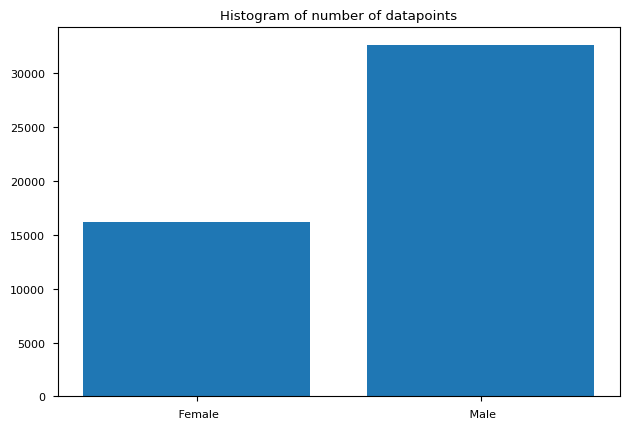

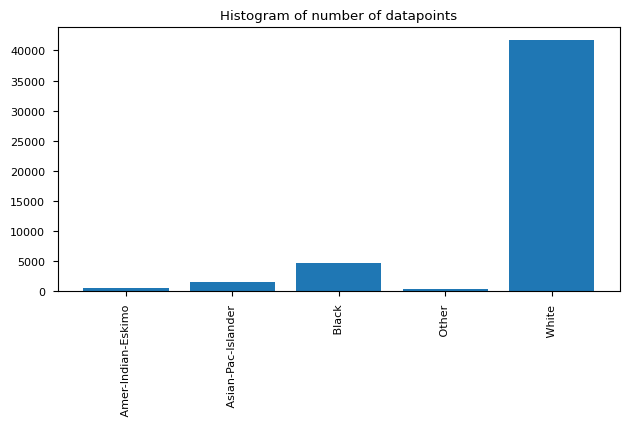

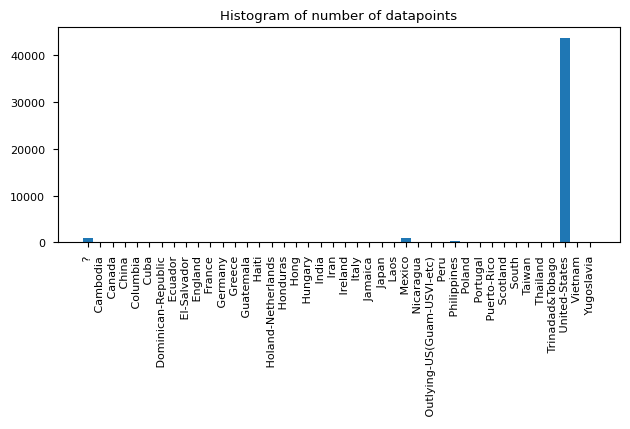

In [8]:
features = ['sex', 'race', 'native-country']
for index, feature in enumerate(features):
    plot_categs(data, feature, fignum=index+1)

## 1.4 Distribution of education level and occupation

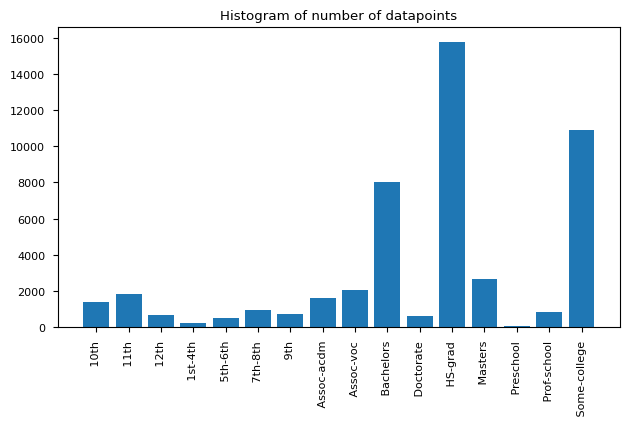

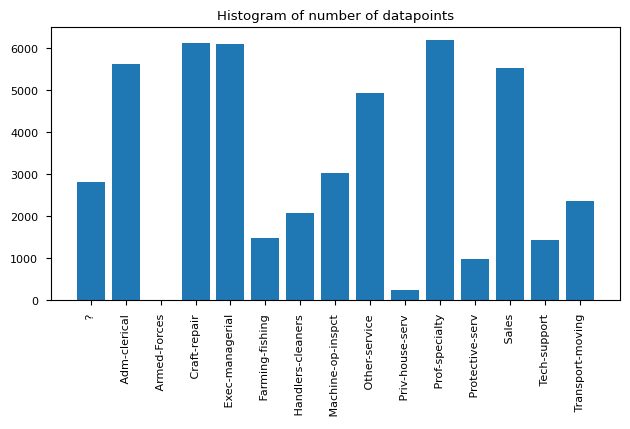

In [9]:
other_features = ['education', 'occupation']
for index, feature in enumerate(other_features):
    plot_categs(data, feature, fignum=index+1)

## 1.5 Distribution of salary among the general population

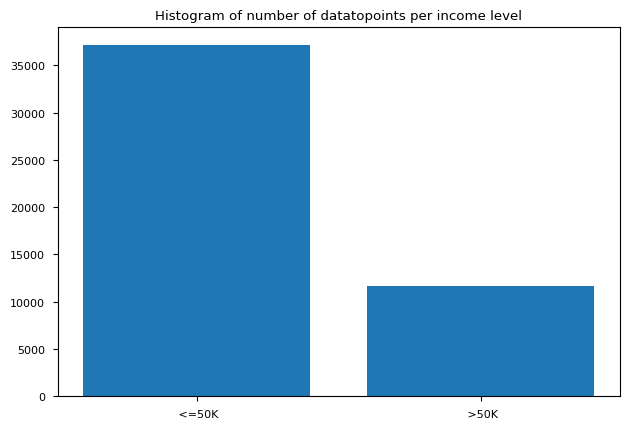

In [10]:
plot_categs(data, 'salary', title="Histogram of number of datatopoints per income level")

### Observation
- The fraction of the population that makes less than 50K is about 3 times the fraction of the population that earns more than 50K.
- How would this affect the predictor trained on this data?

## 1.6 Distribution of salary among people of different gender
Let's now explore the distributiom of salary among people of Male sex versus with the Female sex

In [11]:
def subplot_categs(dfs, titles, category, fignum=1):
    plt.figure(fignum, figsize=(12, 6))
    number_of_dfs = len(titles)
    first_axis = None
    for df_index, df in enumerate(dfs):
        title = titles[df_index]
        uniques = list(sorted(df[category].unique()))
        counts = [df[df[category]==value].shape[0] for value in uniques]
        size = len(uniques)
        xcoords = list(range(1, size+1))
        if df_index == 0:
            first_axis =plt.subplot(1, 2, df_index+1)
        else:
            new_axis = plt.subplot(1, 2, df_index + 1, sharey=first_axis)
        plt.bar(xcoords, counts)
        plt.xticks(xcoords, uniques, rotation='vertical' if size >= 5 else 'horizontal')
        plt.title((title if title else ''))
        plt.tight_layout()

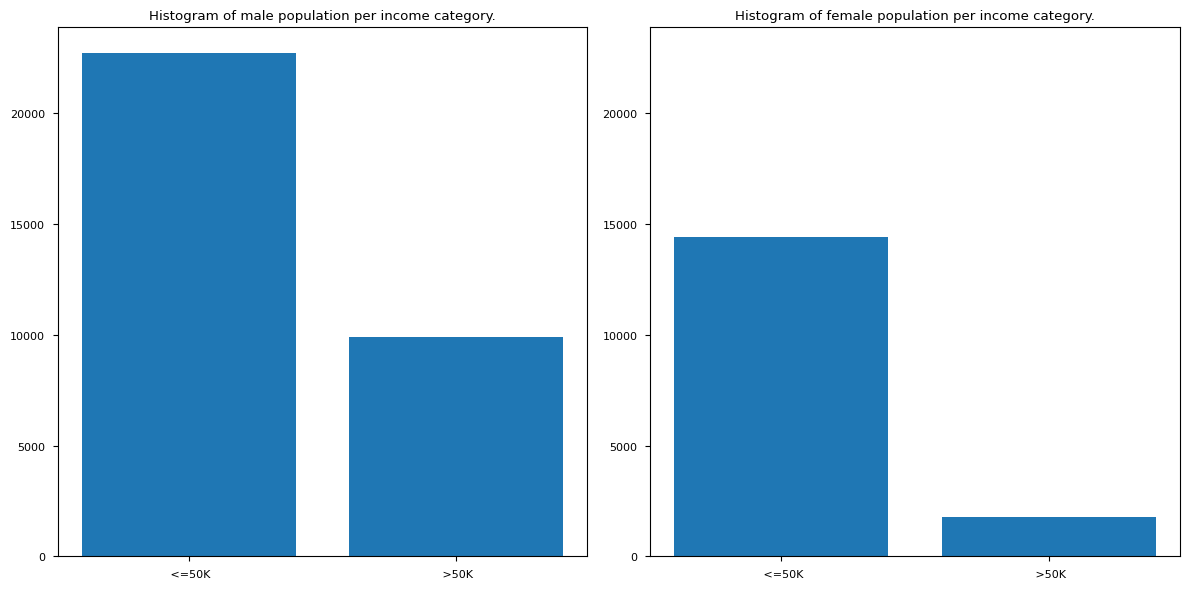

In [12]:
# Examining income category distribution among the male and female demographics
male_data = data[data.sex == ' Male']
female_data = data[data.sex == ' Female']
titles = ['Histogram of male population per income category.', 'Histogram of female population per income category.']
subplot_categs([male_data, female_data], titles, 'salary')

### Observation
- The number of datapoints in the male population is considerably higher than the number of datapoints in the female category, exceeding it by more than 3 times in the higher income category.
- How might this representation disparity affect predictions of a model trained on this data?

## 1.7 Distribution of race in the dataset

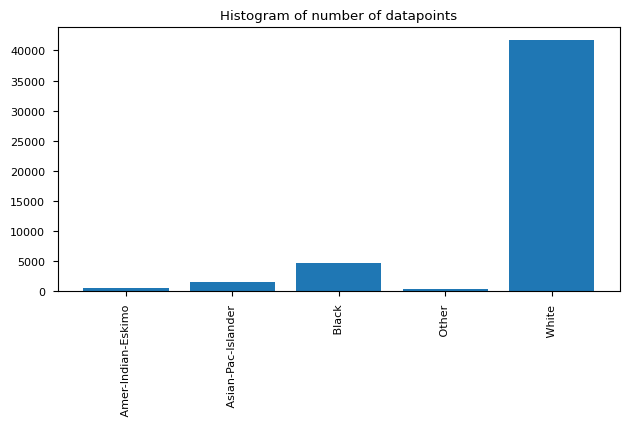

In [13]:
# Examine races in the dataset
plot_categs(data, 'race')

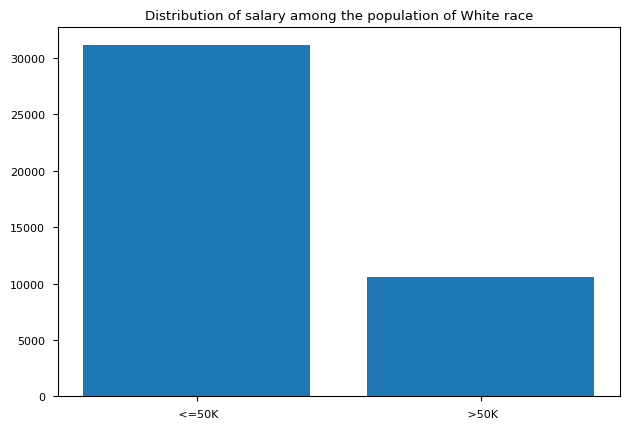

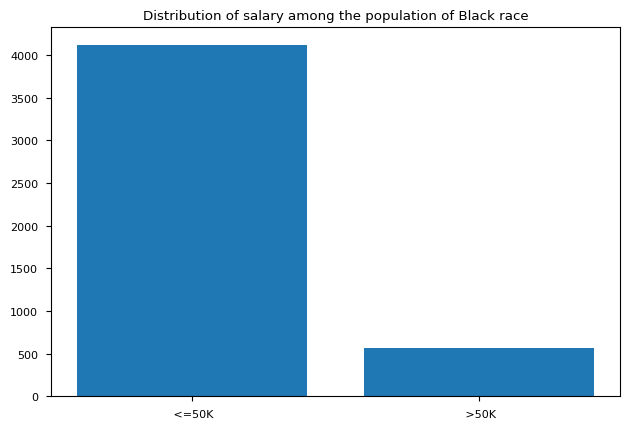

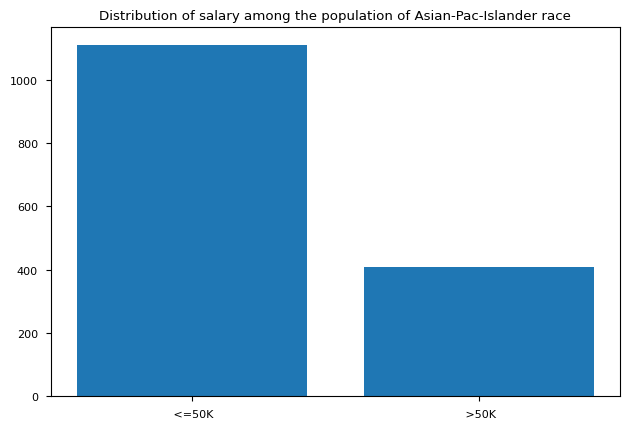

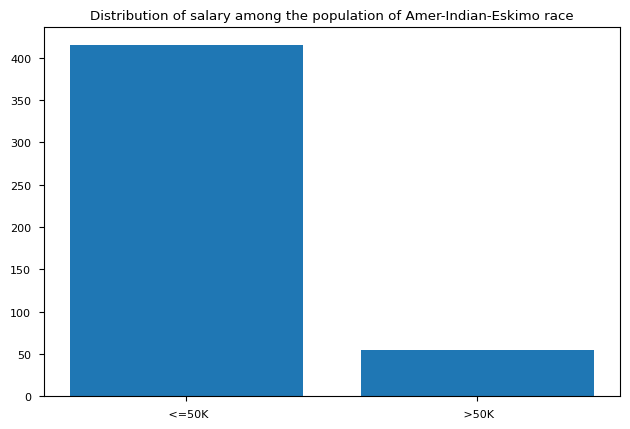

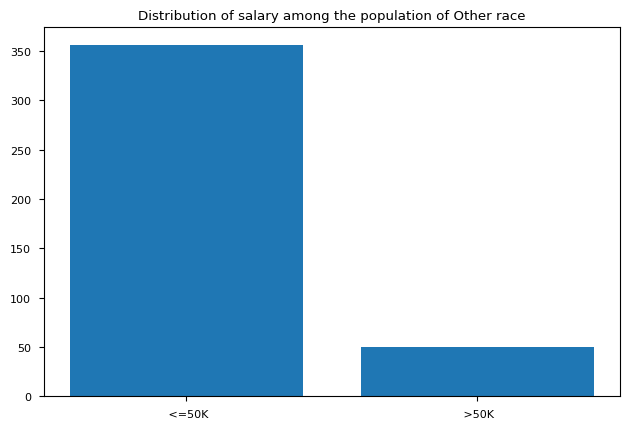

In [14]:
unique_races = data['race'].unique()
for index, race in enumerate(unique_races):
    plot_categs(data[data['race'] == race], 'salary', fignum=index,
                title = "Distribution of salary among the population of"+race+" race")

### Observation
- Different races have different levels of representations in terms of number of datapoints with a given race
- The levels of income distribution among a given race are different
- How could this representation disparity affect a model trained on this data?

## 1.8 Distribution of hours per week

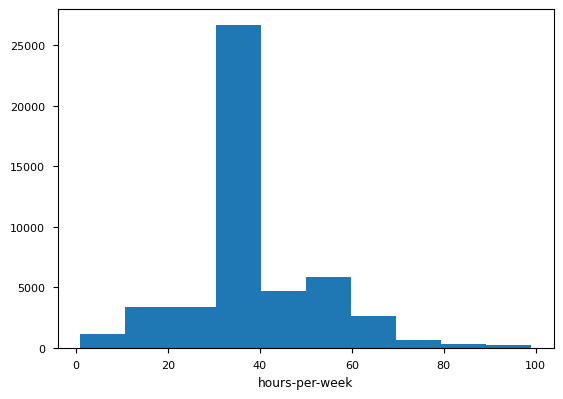

In [15]:
def plot_categ_hists(df, feature, title=None, bins=None, histtype='bar', density=False, normed=None, fignum=1):
    plt.figure(fignum)
    x = df[feature]
    plt.hist(x, bins=bins, density=density, histtype=histtype)
    plt.xlabel(feature)
    plt.title(title if title is not None else '')
plot_categ_hists(data, 'hours-per-week', normed=True, fignum=1)

# 2. Preparing data for predictions
One important step in data science before applying machine learning algorithms is data preparation. In this section, we will be transforming features of our data, so that our dataset can be ready for machine learning

In [16]:
# Create a new dataset to be modified
datav2 = data.copy()
datav2.tail(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K
48841,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K


## 2.1 Drop missing values
Some of the entries in our dataset are either question marks (' ?') or np.nan. Let's simply ignore such entries

In [17]:
# See features with question marks
[feature for feature in datav2.columns if ' ?' in datav2[feature].unique() or np.nan in datav2[feature].unique()]

['workclass', 'occupation', 'native-country']

In [18]:
# Remove all missing values
for feature in datav2.columns:
    datav2[feature] = datav2[feature].replace(' ?', np.nan)
datav2.dropna(how='any', inplace=True)

datav2['native-country'].unique(), datav2['workclass'].unique(), datav2['occupation'].unique()

(array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
        ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
        ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
        ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
        ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
        ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
        ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
        ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
        ' Hungary', ' Holand-Netherlands'], dtype=object),
 array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
        ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object),
 array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
        ' Prof-specialty', ' Other-service', ' Sales', ' Transport-moving',
        ' Farming-fishing', ' Machine-op-inspct', ' Tech-support',
        ' Craft-repai

## 2.2 Converting native country to binary one-hot for US vs non-US

In [19]:
datav2[datav2['native-country'] == ' United-States'].shape

(41292, 15)

In [20]:
datav2.loc[datav2['native-country']!=' United-States', 'native-country'] = 'Non-US'
datav2.loc[datav2['native-country'] == ' United-States', 'native-country'] = 'US'
US_LABEL, NON_US_LABEL = (0, 1)
datav2['native-country'] = datav2['native-country'].map({'US':US_LABEL,'Non-US':NON_US_LABEL}).astype(int)
datav2.tail(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
48836,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,0,<=50K
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,0,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,0,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,0,<=50K
48841,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,0,>50K


## 2.3 Converting sex and salary to binary one-hot

In [21]:
FEMALE_LABEL, MALE_LABEL = (0, 1)
HIGH_SALARY_LABEL, LOW_SALARY_LABEL = (0, 1)

In [22]:
datav2['salary'] = datav2['salary'].map({' >50K':HIGH_SALARY_LABEL,' <=50K':LOW_SALARY_LABEL})
datav2['sex'] = datav2['sex'].map({' Male':MALE_LABEL,' Female':FEMALE_LABEL})
datav2.tail(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
48836,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,1,0,0,40,0,1
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,0,0,0,36,0,1
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,1,0,0,50,0,1
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,1,5455,0,40,0,1
48841,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,60,0,0


## 2.4 Transform marital status to single or couple

In [23]:
datav2['marital-status'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [24]:
datav2['marital-status'] = datav2['marital-status'].replace([' Divorced',' Married-spouse-absent',' Never-married',' Separated',' Widowed'],'Single')
datav2['marital-status'] = datav2['marital-status'].replace([' Married-AF-spouse',' Married-civ-spouse'],'Couple')
datav2.head(-5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Single,Adm-clerical,Not-in-family,White,1,2174,0,40,0,1
1,50,Self-emp-not-inc,83311,Bachelors,13,Couple,Exec-managerial,Husband,White,1,0,0,13,0,1
2,38,Private,215646,HS-grad,9,Single,Handlers-cleaners,Not-in-family,White,1,0,0,40,0,1
3,53,Private,234721,11th,7,Couple,Handlers-cleaners,Husband,Black,1,0,0,40,0,1
4,28,Private,338409,Bachelors,13,Couple,Prof-specialty,Wife,Black,0,0,0,40,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48831,48,Private,285570,HS-grad,9,Couple,Adm-clerical,Husband,White,1,0,0,40,0,1
48832,61,Private,89686,HS-grad,9,Couple,Sales,Husband,White,1,0,0,48,0,1
48833,31,Private,440129,HS-grad,9,Couple,Craft-repair,Husband,White,1,0,0,40,0,1
48834,25,Private,350977,HS-grad,9,Single,Other-service,Own-child,White,0,0,0,40,0,1


## 2.5 Convert marital status to binary one-hot

In [25]:
COUPLE_STATUS_LABEL, SINGLE_STATUS_LABEL = (0, 1)
datav2['marital-status'] = datav2['marital-status'].map({'Couple':COUPLE_STATUS_LABEL,'Single':SINGLE_STATUS_LABEL})
datav2.tail(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
48836,33,Private,245211,Bachelors,13,1,Prof-specialty,Own-child,White,1,0,0,40,0,1
48837,39,Private,215419,Bachelors,13,1,Prof-specialty,Not-in-family,White,0,0,0,36,0,1
48839,38,Private,374983,Bachelors,13,0,Prof-specialty,Husband,White,1,0,0,50,0,1
48840,44,Private,83891,Bachelors,13,1,Adm-clerical,Own-child,Asian-Pac-Islander,1,5455,0,40,0,1
48841,35,Self-emp-inc,182148,Bachelors,13,0,Exec-managerial,Husband,White,1,0,0,60,0,0


## 2.6 Convert relationships to one-hot
Remember that one-hot encoding helps us represent data of multiple categories. Let's do this for relationships

In [26]:
# First convert relationship to integers
rel_map = {' Unmarried':0,' Wife':1,' Husband':2,' Not-in-family':3,' Own-child':4,' Other-relative':5}
datav2['relationship'] = datav2['relationship'].map(rel_map)
datav2.tail(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
48831,48,Private,285570,HS-grad,9,0,Adm-clerical,2,White,1,0,0,40,0,1
48832,61,Private,89686,HS-grad,9,0,Sales,2,White,1,0,0,48,0,1
48833,31,Private,440129,HS-grad,9,0,Craft-repair,2,White,1,0,0,40,0,1
48834,25,Private,350977,HS-grad,9,1,Other-service,4,White,0,0,0,40,0,1
48835,48,Local-gov,349230,Masters,14,1,Other-service,3,White,1,0,0,40,0,1
48836,33,Private,245211,Bachelors,13,1,Prof-specialty,4,White,1,0,0,40,0,1
48837,39,Private,215419,Bachelors,13,1,Prof-specialty,3,White,0,0,0,36,0,1
48839,38,Private,374983,Bachelors,13,0,Prof-specialty,2,White,1,0,0,50,0,1
48840,44,Private,83891,Bachelors,13,1,Adm-clerical,4,Asian-Pac-Islander,1,5455,0,40,0,1
48841,35,Self-emp-inc,182148,Bachelors,13,0,Exec-managerial,2,White,1,0,0,60,0,0


In [27]:
# Now convert relationship from integer to one-hot
datav2 = pd.get_dummies(datav2, columns=['relationship'])
datav2.tail(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,relationship_0,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5
48836,33,Private,245211,Bachelors,13,1,Prof-specialty,White,1,0,0,40,0,1,False,False,False,False,True,False
48837,39,Private,215419,Bachelors,13,1,Prof-specialty,White,0,0,0,36,0,1,False,False,False,True,False,False
48839,38,Private,374983,Bachelors,13,0,Prof-specialty,White,1,0,0,50,0,1,False,False,True,False,False,False
48840,44,Private,83891,Bachelors,13,1,Adm-clerical,Asian-Pac-Islander,1,5455,0,40,0,1,False,False,False,False,True,False
48841,35,Self-emp-inc,182148,Bachelors,13,0,Exec-managerial,White,1,0,0,60,0,0,False,False,True,False,False,False


## 2.7 Convert race to one-hot
As we did for relationships, we know convert race representation to one-hot encoding

In [28]:
# Convert to integers first
race_map={' White':0,' Amer-Indian-Eskimo':1,' Asian-Pac-Islander':2,' Black':3,' Other':4}
datav2['race']= datav2['race'].map(race_map)
# Convert from integer to one_hot
datav2 = pd.get_dummies(datav2, columns=['race'])
datav2.tail(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,sex,capital-gain,capital-loss,...,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,race_0,race_1,race_2,race_3,race_4
48836,33,Private,245211,Bachelors,13,1,Prof-specialty,1,0,0,...,False,False,False,True,False,True,False,False,False,False
48837,39,Private,215419,Bachelors,13,1,Prof-specialty,0,0,0,...,False,False,True,False,False,True,False,False,False,False
48839,38,Private,374983,Bachelors,13,0,Prof-specialty,1,0,0,...,False,True,False,False,False,True,False,False,False,False
48840,44,Private,83891,Bachelors,13,1,Adm-clerical,1,5455,0,...,False,False,False,True,False,False,False,True,False,False
48841,35,Self-emp-inc,182148,Bachelors,13,0,Exec-managerial,1,0,0,...,False,True,False,False,False,True,False,False,False,False


## 2.8 Transform workclass feature
We first start by categorizing workclass as government, private or without pay

In [29]:
def group_workclass(x):
    if x['workclass'] == ' Federal-gov' or x['workclass']== ' Local-gov' or x['workclass']==' State-gov': return 'govt'
    elif x['workclass'] == ' Private':return 'private'
    elif x['workclass'] == ' Self-emp-inc' or x['workclass'] == ' Self-emp-not-inc': return 'self_employed'
    else: return 'without_pay'

datav2['workclass']=datav2.apply(group_workclass, axis=1)

datav2['workclass'] = datav2['workclass'].map({'govt':0,'private':1,'self_employed':2,'without_pay':3})
datav2 = pd.get_dummies(datav2, columns=['workclass'])
datav2.tail(5)

,age,fnlwgt,education,education-num,marital-status,occupation,sex,capital-gain,capital-loss,hours-per-week,...,relationship_5,race_0,race_1,race_2,race_3,race_4,workclass_0,workclass_1,workclass_2,workclass_3
48836,33,245211,Bachelors,13,1,Prof-specialty,1,0,0,40,...,False,True,False,False,False,False,False,True,False,False
48837,39,215419,Bachelors,13,1,Prof-specialty,0,0,0,36,...,False,True,False,False,False,False,False,True,False,False
48839,38,374983,Bachelors,13,0,Prof-specialty,1,0,0,50,...,False,True,False,False,False,False,False,True,False,False
48840,44,83891,Bachelors,13,1,Adm-clerical,1,5455,0,40,...,False,False,False,True,False,False,False,True,False,False
48841,35,182148,Bachelors,13,0,Exec-managerial,1,0,0,60,...,False,True,False,False,False,False,False,False,True,False


## 2.9 Convert occupation to one-hot

In [30]:
occupation_map = dict((value, key) for (key, value) in enumerate(datav2.occupation.unique()))
datav2['occupation'] = datav2['occupation'].map(occupation_map)
datav2 = pd.get_dummies(datav2, columns=['occupation'])
datav2.tail(5)

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
48836,33,245211,Bachelors,13,1,1,0,0,40,0,...,False,False,False,False,False,False,False,False,False,False
48837,39,215419,Bachelors,13,1,0,0,0,36,0,...,False,False,False,False,False,False,False,False,False,False
48839,38,374983,Bachelors,13,0,1,0,0,50,0,...,False,False,False,False,False,False,False,False,False,False
48840,44,83891,Bachelors,13,1,1,5455,0,40,0,...,False,False,False,False,False,False,False,False,False,False
48841,35,182148,Bachelors,13,0,1,0,0,60,0,...,False,False,False,False,False,False,False,False,False,False


## 2.10 Convert captial-gain and capital-loss to categorical

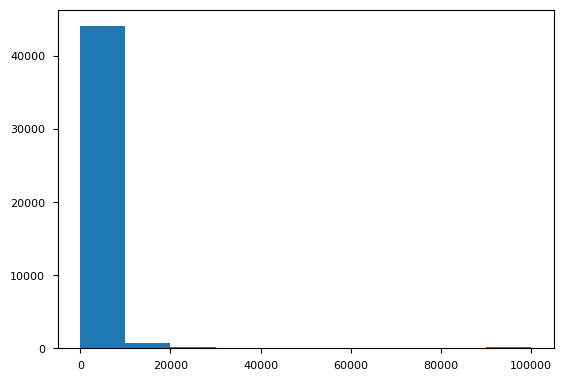

In [31]:
capital_gain, capital_loss, =datav2['capital-gain'], datav2['capital-loss']
plt.hist(capital_gain,bins=None)
plt.show()

In [32]:
datav2.loc[(datav2['capital-gain'] > 0),'capital-gain'] = 1
datav2.loc[(datav2['capital-gain'] == 0 ,'capital-gain')]= 0
datav2.tail(5)

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
48836,33,245211,Bachelors,13,1,1,0,0,40,0,...,False,False,False,False,False,False,False,False,False,False
48837,39,215419,Bachelors,13,1,0,0,0,36,0,...,False,False,False,False,False,False,False,False,False,False
48839,38,374983,Bachelors,13,0,1,0,0,50,0,...,False,False,False,False,False,False,False,False,False,False
48840,44,83891,Bachelors,13,1,1,1,0,40,0,...,False,False,False,False,False,False,False,False,False,False
48841,35,182148,Bachelors,13,0,1,0,0,60,0,...,False,False,False,False,False,False,False,False,False,False


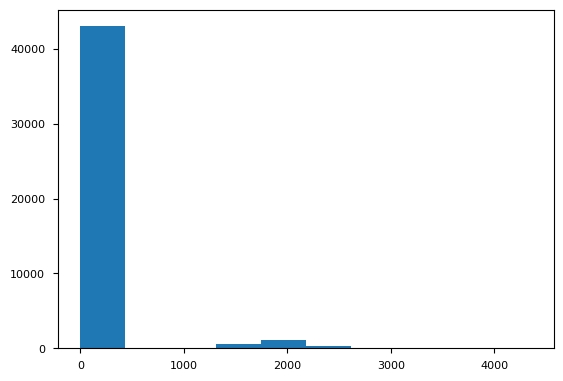

In [33]:
x = datav2['capital-loss']
plt.hist(x,bins=None)
plt.show()

In [34]:
datav2.loc[(datav2['capital-loss'] > 0),'capital-loss'] = 1
datav2.loc[(datav2['capital-loss'] == 0 ,'capital-loss')]= 0
datav2.tail(5)

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
48836,33,245211,Bachelors,13,1,1,0,0,40,0,...,False,False,False,False,False,False,False,False,False,False
48837,39,215419,Bachelors,13,1,0,0,0,36,0,...,False,False,False,False,False,False,False,False,False,False
48839,38,374983,Bachelors,13,0,1,0,0,50,0,...,False,False,False,False,False,False,False,False,False,False
48840,44,83891,Bachelors,13,1,1,1,0,40,0,...,False,False,False,False,False,False,False,False,False,False
48841,35,182148,Bachelors,13,0,1,0,0,60,0,...,False,False,False,False,False,False,False,False,False,False


# 3. Predicting individual's income without auditing bias

In [35]:
# Normalize continuous features
continuous_features = ['age', 'fnlwgt', 'education-num', 'hours-per-week']
X = datav2[continuous_features]
datav2[continuous_features] = (X - np.mean(X))/ np.std(X)
datav2.tail(5)

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
48836,-3587.840419,1.872005,Bachelors,-18584.33888,1,1,0,0,-3948.913300,0,...,False,False,False,False,False,False,False,False,False,False
48837,-3587.386483,1.589985,Bachelors,-18584.33888,1,0,0,0,-3949.246429,0,...,False,False,False,False,False,False,False,False,False,False
48839,-3587.462139,3.100464,Bachelors,-18584.33888,0,1,0,0,-3948.080479,0,...,False,False,False,False,False,False,False,False,False,False
48840,-3587.008203,0.344903,Bachelors,-18584.33888,1,1,1,0,-3948.913300,0,...,False,False,False,False,False,False,False,False,False,False
48841,-3587.689107,1.275032,Bachelors,-18584.33888,0,1,0,0,-3947.247657,0,...,False,False,False,False,False,False,False,False,False,False


In [36]:
datav2 = datav2.drop(['education'], axis=1)

## 3.1 Train a machine learning algorithm on the data
We will train a classifier on the dataset, and use it to make predictions. Let's use a Multi-layer Perceptron classifier with default parameters. This model optimizes the log-loss function using LBFGS or stochastic gradient descent.

In [37]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [38]:
def get_naive_dataset(dataset):
    data_shuffled = dataset.sample(frac=1).reset_index(drop=True)
    X = data_shuffled.drop(['salary'], axis=1)
    y = data_shuffled['salary']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    return (x_train, y_train), (x_test, y_test)

In [39]:
#MLP_MAX_ITER=10000
MLP_MAX_ITER=200

In [40]:
(x_train, y_train), (x_test, y_test) = get_naive_dataset(datav2)
model = MLPClassifier(max_iter=MLP_MAX_ITER)
model.fit(x_train,y_train)
prediction = model.predict(x_test)

## 3.2 Evaluating algorithm's performance

In [41]:
test_df = x_test.copy()
test_df['salary'] = y_test
test_df['pred'] = pd.Series(prediction, index=test_df.index)
test_df['accurate'] = (test_df['pred'] == test_df['salary'])
test_df.tail(5)

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,relationship_0,...,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,salary,pred,accurate
1971,-3587.386483,-0.204946,-18583.947161,0,1,0,0,-3948.247043,1,False,...,False,False,False,False,False,False,False,1,1,True
41567,-3586.705579,0.498030,-18585.514035,1,0,0,0,-3948.913300,0,True,...,False,False,False,False,False,False,False,1,1,True
18600,-3585.268116,2.905667,-18585.905754,1,0,0,0,-3950.578943,0,False,...,False,False,False,False,False,False,False,1,1,True
23453,-3587.008203,1.354388,-18584.338880,1,0,0,0,-3949.329711,0,True,...,False,False,False,False,False,False,False,1,1,True
2893,-3588.521323,0.444337,-18585.514035,1,1,0,0,-3948.913300,0,False,...,False,False,False,True,False,False,False,1,1,True


In [42]:
"Accuracy: ", test_df.accurate.mean()

('Accuracy: ', np.float64(0.7572085618255794))

## 3.3 Understanding gender bias in machine learning predictions

In [45]:
def evaluate_gender_performance(results_df, print_stats=False):
    """
    TODO:
        - method documentation
        - DRYing
    """
    def printline():
        _print('-------------------------------------------------')

    def _print(*args, **kwargs):
        if print_stats:
            print (args, kwargs)

    summaries = {}
    overall_accuracy = results_df.accurate.mean()
    summaries['accuracy_overall'] = overall_accuracy
    printline()
    _print("\n1.Overall accuracy: ", overall_accuracy)

    printline()

    # Accuracy accross gender
    _print("\n2.Accuracy accross gender \n ")
    printline
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        accuracy_for_gender = rows.accurate.mean();
        summaries['accuracy_'+gender[1]] = accuracy_for_gender
        _print("P(((high, HIGH) or (low, LOW)) |", gender[1], "): ", accuracy_for_gender)
    printline()

    _print("\n3.Positive Rates: \n")
    # High income rate given gender
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        positive_rate_for_gender = (rows['pred'] ==HIGH_SALARY_LABEL).mean()
        summaries['positive_rate_'+gender[1]] = positive_rate_for_gender
        _print("P(high|", gender[1], "): ", positive_rate_for_gender)
    printline()

    _print("\n4. Negative Rates: \n")

    # Low income rate given gender
    # High income rate given gender
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        positive_rate_for_gender = (rows['pred'] ==LOW_SALARY_LABEL).mean()
        summaries['negative_rate_'+gender[1]] = positive_rate_for_gender
        _print("P(low|", gender[1], "): ", positive_rate_for_gender)
    printline()

    _print("\n4. True positive and True negative rates")

    printline()

    for index, gender in enumerate([(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]):

        _print("\n4."+("i")*(1+index), " True positive and negative rates on sex="+gender[1], "\n")
        rows = results_df[results_df.sex==gender[0]]

        high_income = rows[rows.salary== HIGH_SALARY_LABEL]
        low_income=rows[rows.salary == LOW_SALARY_LABEL]
        if high_income.shape[0] > 0:
            assert high_income.salary.mean() == HIGH_SALARY_LABEL, "high_mean: " + str(high_income.salary.mean())
        if low_income.shape[0] > 0:
            assert low_income.salary.mean() == LOW_SALARY_LABEL, "low_mean: " + str(low_income.salary.mean())

        high_pred = rows[rows.pred == HIGH_SALARY_LABEL]
        low_pred = rows[rows.pred == LOW_SALARY_LABEL]
        if high_pred.shape[0] > 0:
            assert high_pred.pred.mean() == HIGH_SALARY_LABEL, "high_pred_mean: " + str(high_pred.pred.mean())
        if low_pred.shape[0] > 0:
            assert low_pred.pred.mean() == LOW_SALARY_LABEL, "low_pred_mean: " + str(low_pred.pred.mean())

        printline()
        true_positive_rate = high_income.accurate.mean()
        true_negative_rate = low_income.accurate.mean()
        summaries['true_positive_rate_'+gender[1]] = true_positive_rate
        summaries['true_negative_rate_'+gender[1]] = true_negative_rate

        _print(str.format("P((high, HIGH)| HIGH,{0})", gender[1]), ": ",true_positive_rate)
        _print(str.format("P((low, LOW)| LOW,{0})", gender[1]), ":",true_negative_rate)

        printline()
        true_positive_rate_on_positive_predictions = high_pred.accurate.mean()
        true_negative_rate_on_negative_predictions = low_pred.accurate.mean()
        summaries['true_positive_rate_on_positive_predictions_'+gender[1]] = true_positive_rate_on_positive_predictions
        summaries['true_negative_rate_on_negative_predictions_'+gender[1]] = true_negative_rate_on_negative_predictions
        _print(str.format("P((high,HIGH) | high, {0})", gender[1]), ": ",true_positive_rate_on_positive_predictions)
        _print(str.format("P((low,LOW) |low,{0})", gender[1]), ":", true_negative_rate_on_negative_predictions)
        #true_positive_rate_on_positive_predictions = high_pred.accurate.mean()
        #true_negative_rate_on_negative_predictions = low_pred.accurate.mean()
        #summaries['true_positive_rate_on_positive_predictions_'+gender[1]] = true_positive_rate_on_positive_predictions
        #summaries['true_negative_rate_on_negative_predictions_'+gender[1]] = true_negative_rate_on_negative_predictions
        #_print(str.format("P((high,HIGH) | high, {0})", gender[1]), ": ",true_positive_rate_on_positive_predictions)
        #_print(str.format("P((low,LOW) |low,{0})", gender[1]), ":", true_negative_rate_on_negative_predictions)


    return summaries

def plot_performance_per_group(accuracy_results, title, fignum=1, rotation='horizontal', labels=["Male", "Female"]):

    """
    Plot results for 2 groups stacked together
    """
    assert isinstance(accuracy_results, list), "Accuracy results must be a list"


    indices = [0]
    colors = ['deepskyblue', 'lightsalmon']
    fig, ax = plt.subplots()

    for index in indices:
        ax.scatter(index, accuracy_results[0][index], c=colors[0], label=labels[0] if labels and index ==0 else None)
        ax.scatter(index, accuracy_results[1][index], c=colors[1], label=labels[1] if labels and index ==0 else None)

    if labels:
        ax.legend()

    #plt.xticks(indices, approaches, rotation=rotation)
    plt.title(title)

    plt.show()


def plot_comparisons_groups(approaches, accuracy_results, title, fignum=1, rotation='horizontal', labels=["Male", "Female"]):
    """
    Plot results for 2 groups stacked together
    """
    assert isinstance(accuracy_results, list), "Accuracy results must be a list"


    indices = list(range(len(approaches)))
    colors = ['deepskyblue', 'lightsalmon']
    fig, ax = plt.subplots()

    for index in indices:
        ax.scatter(index, accuracy_results[0][index], c=colors[0], label=labels[0] if labels and index ==0 else None)
        ax.scatter(index, accuracy_results[1][index], c=colors[1], label=labels[1] if labels and index ==0 else None)

    if labels:
        ax.legend()

    plt.xticks(indices, approaches, rotation=rotation)
    plt.title(title)

    plt.show()

def plot_model_gender_metrics(_feature, _summaries, _modelNames, _title, rotation='vertical'):
    gender_metrics = [[summary[_feature+'_Male'] for summary in _summaries],
                         [summary[_feature+'_Female'] for summary in _summaries]
                        ]
    plot_comparisons_groups(_modelNames,gender_metrics, _title, rotation=rotation)

def model_summary(model_name, title, summary):
    summaries = []
    model_names = []

    for key in ["accuracy", "positive_rate", "negative_rate", "true_positive_rate", "true_negative_rate"]:
        new_summary = {"accuracy_Male": summary[key+"_Male"], "accuracy_Female": summary[key+"_Female"]}
        summaries.append(new_summary)
        model_names.append(key)
    plot_model_gender_metrics("accuracy", summaries, model_names, model_name)
    #plot_model_gender_metrics(key, [summary], [model_name], "Model="+model_name+", Metric="+key, rotation="horizontal")

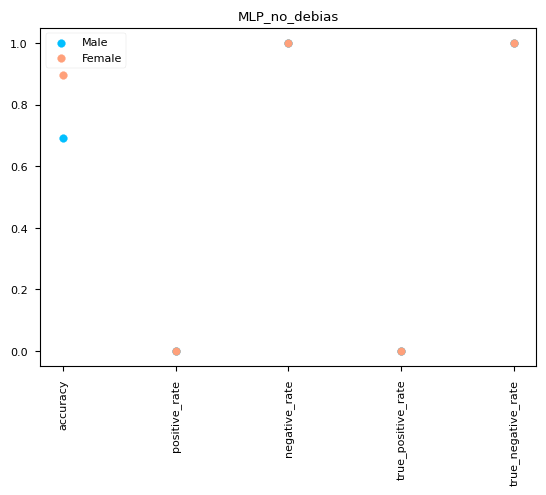

In [46]:
original_approach = evaluate_gender_performance(test_df)
model_summary("MLP_no_debias", "", original_approach)

## 3.4 Plot learning curve

In [47]:
default_training_sizes = [1000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000]
#default_training_sizes = [1000, 5000, 15000, 25000, 35000, 45000]

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, lrxtrain, lrytrain, train_sizes, title=None):
    _train_sizes = []
    for size in train_sizes:
        if size <= lrxtrain.shape[0]*.65:
            _train_sizes.append(size)
        else:
            break
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, lrxtrain, lrytrain, train_sizes = _train_sizes, scoring = 'neg_log_loss')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('NLL', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()

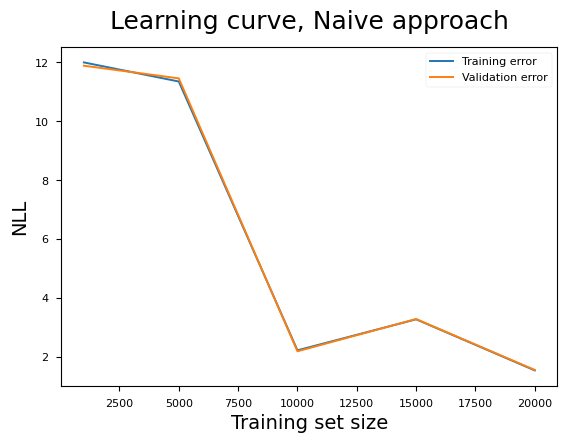

In [48]:
plot_learning_curve(MLPClassifier(), x_train, y_train, default_training_sizes, "Learning curve, Naive approach")

## Introducing Bias metrics
The two most used bias metrics are **statistical parity**, and **equality of opportunity**.

# 4. Bias mitigation techniques
In this section, we will be exploring two main techniques for reducing bias in machine learning. The first technique is called unawareness, and the second technique is database re-balancing.

## 4.1 Mitigation through unawareness
In this technique, we attempt to decrease algorithmic bias by removing sensitive/protected attributes from training data. This is called unawareness.

In [50]:
def get_unawareness_dataset(dataset):
    (x_train, y_train), (x_test, y_test) = get_naive_dataset(dataset)
    testdata = x_test.copy()
    assert "sex" in list(testdata.columns), ("columns: ", list(testdata.columns))

    x_train, x_test = [v.drop(['sex'], axis=1) for v in (x_train, x_test)]
    return (x_train, y_train), (x_test, y_test), testdata

In [51]:
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
(x_train, ytrain), (x_test, y_test), testdata = get_unawareness_dataset(datav2)
predictor.fit(x_train, y_train)

MLPClassifier()

In [52]:
def evaluate_predictor_performance(predictions, x_test, y_test):
    """
    Returns summary statistics for the predictor's performance

    Input:
        - predictions: model's predictions on x_test
        - x_test: test input
        - y_test: test labels

    Requires:
        - predictor must have been fitted on x_train and y_train from the same dataset

    Check method evaluate_gender_performance for more on the produced summary statistics
    """
    testdata = x_test.copy()
    testdata['salary'] = y_test
    testdata['pred'] = pd.Series(predictions, index=x_test.index)
    testdata['accurate'] = (testdata['pred'] == testdata['salary'])
    return evaluate_gender_performance(testdata)

## 4.1.1 Analysing performance

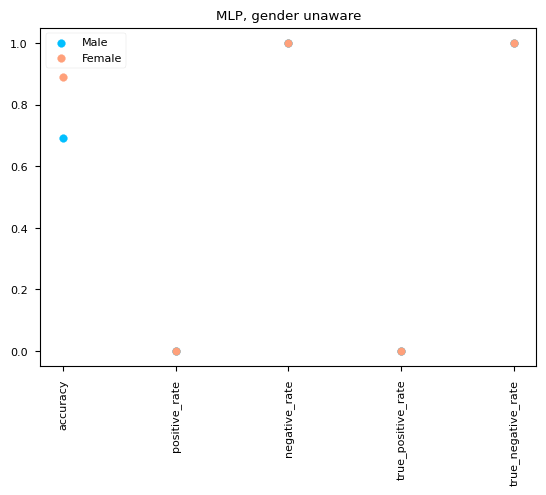

In [53]:
predictions = predictor.predict(x_test)
approach_1 = evaluate_predictor_performance(predictions, testdata, y_test)
model_summary("MLP, gender unaware", "", approach_1)

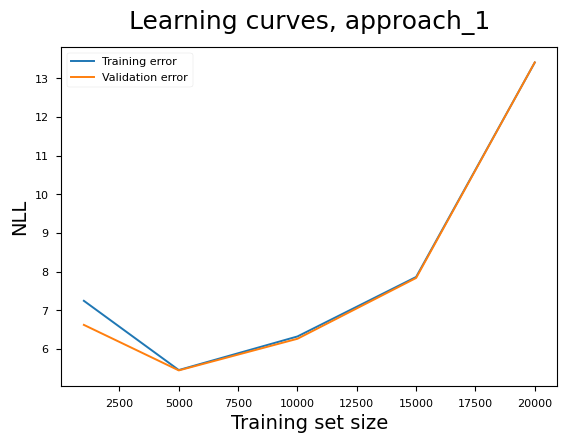

In [54]:
plot_learning_curve(MLPClassifier(), x_train, y_train, default_training_sizes, 'Learning curves, approach_1')

## 4.2 Mitigation through dataset balancing

### 4.2.1 Equal number of datapoints per demographic
In this approach, we attempt to balance the dataset by drawing equal number of samples from the male and female demographics.

In [55]:
def get_gender_balanced_dataset(dataset, test_size=0.25):
    """
    Returns (x_train, y_train), (x_test, y_test) with equal number of samples for each gender
    """
    males, females = dataset[dataset.sex == MALE_LABEL], dataset[dataset.sex==FEMALE_LABEL]
    sampled_males = males.sample(n=int(min(females.shape[0], males.shape[0]))).reset_index(drop=True)
    combined = pd.concat([sampled_males, females]).sample(frac=1).reset_index(drop=True)
    Xvals=combined.drop(["salary"], axis=1)
    Yvals = combined["salary"]
    x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=test_size)
    return (x_train, y_train), (x_test, y_test)

In [56]:
datav3 = datav2.copy()
datav3.tail(5)

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
48836,-3587.840419,1.872005,-18584.33888,1,1,0,0,-3948.913300,0,1,...,False,False,False,False,False,False,False,False,False,False
48837,-3587.386483,1.589985,-18584.33888,1,0,0,0,-3949.246429,0,1,...,False,False,False,False,False,False,False,False,False,False
48839,-3587.462139,3.100464,-18584.33888,0,1,0,0,-3948.080479,0,1,...,False,False,False,False,False,False,False,False,False,False
48840,-3587.008203,0.344903,-18584.33888,1,1,1,0,-3948.913300,0,1,...,False,False,False,False,False,False,False,False,False,False
48841,-3587.689107,1.275032,-18584.33888,0,1,0,0,-3947.247657,0,0,...,False,False,False,False,False,False,False,False,False,False


In [57]:
(x_train, y_train), (x_test, y_test) = get_gender_balanced_dataset(datav3)
x_train.shape, x_test.shape

((22042, 38), (7348, 38))

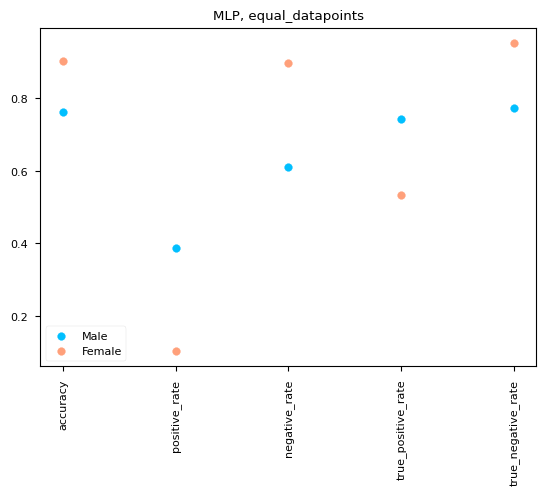

In [58]:
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train, y_train)
approach_2 = evaluate_predictor_performance(predictor.predict(x_test), x_test, y_test)
model_summary("MLP, equal_datapoints", "", approach_2)

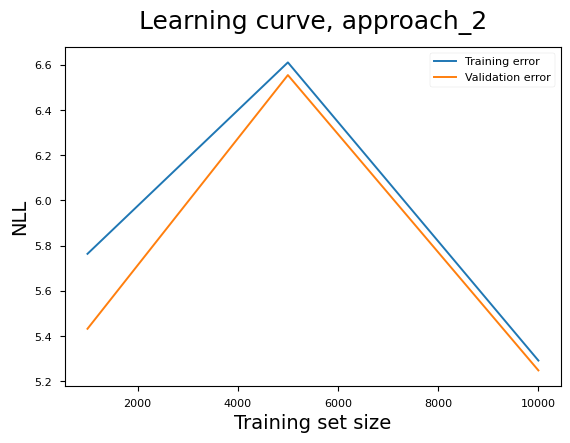

In [59]:
plot_learning_curve(MLPClassifier(), x_train, y_train, default_training_sizes, 'Learning curve, approach_2')

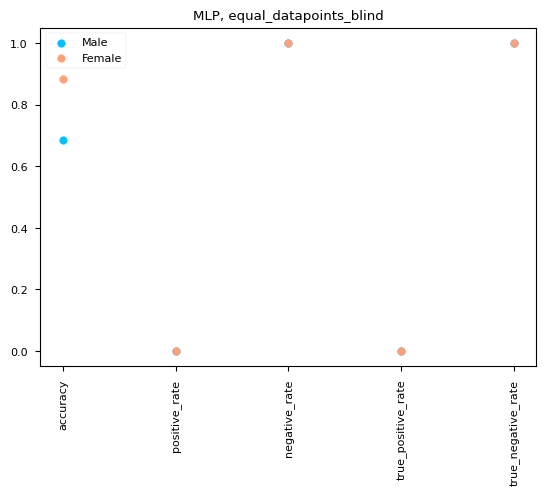

In [60]:
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train.drop(['sex'], axis=1), y_train)
approach_2_blind = evaluate_predictor_performance(predictor.predict(x_test.drop(['sex'], axis=1)), x_test, y_test)
model_summary("MLP, equal_datapoints_blind", "", approach_2_blind)

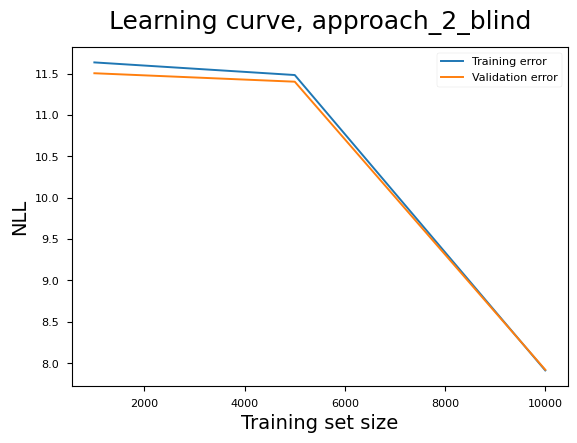

In [61]:
plot_learning_curve(MLPClassifier(), x_train, y_train, default_training_sizes, 'Learning curve, approach_2_blind')

### 4.2.2 Equal number of datapoints per demographic in each category
In this approach, we draw an equal number of data points from the subset of male individuals with a high income, male individuals with a low income, female individuals with a high income and female individuals with a low income

In [62]:
def get_gender_category_balanced_dataset(dataset, test_size=0.25):
    """
    Equal number of datapoints per category. Limited by the smallest number of points
    """
    # Old distribution categories
    males = dataset[(dataset.sex==MALE_LABEL)]
    females = dataset[(dataset.sex==FEMALE_LABEL)]
    male_high = males[(males.salary == HIGH_SALARY_LABEL)]
    male_low = males[(males.salary == LOW_SALARY_LABEL)]
    female_high = females[(females.salary == HIGH_SALARY_LABEL)]
    female_low = females[(females.salary == LOW_SALARY_LABEL)]

    # Smallest is the bottleneck
    smallest = min((x.shape[0] for x in [male_high, male_low, female_high, female_low]))

    # New distribution categories
    _male_high = male_high.sample(n=smallest).reset_index(drop=True)
    _male_low = male_low.sample(n=smallest).reset_index(drop=True)
    _female_high = female_high.sample(n=smallest).reset_index(drop=True)
    _female_low = female_low.sample(n=smallest).reset_index(drop=True)
    _combined = pd.concat([_male_high, _male_low, _female_high, _female_low]).sample(frac=1).reset_index(drop=True)

    Xvals=_combined.drop(["salary"], axis=1)
    Yvals = _combined["salary"]
    x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=test_size)
    return (x_train, y_train), (x_test, y_test)

We now train a new predictor on the new balanced dataset

In [63]:
(x_train, y_train), (x_test, y_test) = get_gender_category_balanced_dataset(datav3)

predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train, y_train)
predictions = predictor.predict(x_test)

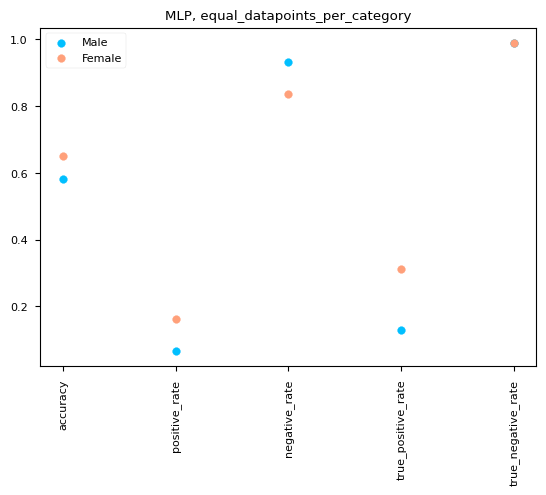

In [64]:
approach_3 = evaluate_predictor_performance(predictions, x_test, y_test)
model_summary("MLP, equal_datapoints_per_category", "", approach_3)

In [ ]:
#plot_learning_curve(MLPClassifier(), x_train, y_train, default_training_sizes, 'Learning curve, approach_3')

#### Equal number of datapoints and gender unawareness

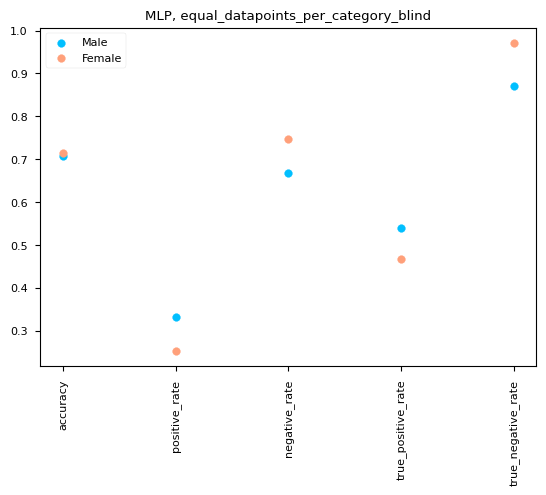

In [65]:
(x_train, y_train), (x_test, y_test) = get_gender_category_balanced_dataset(datav3)

predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train.drop(['sex'], axis=1), y_train)
predictions = predictor.predict(x_test.drop(['sex'], axis=1))
approach_3_blind = evaluate_predictor_performance(predictions, x_test, y_test)
model_summary("MLP, equal_datapoints_per_category_blind", "", approach_3_blind)

In [ ]:
#plot_learning_curve(MLPClassifier(), x_train, y_train, default_training_sizes, 'Learning curve, approach_3_blind')

### 4.2.3 Equal ratios instead of equal number of datapoints
In this section, we balance the dataset by preserving the ratio of the the size of the population in a given demographic with a given income level in a way that maximizes the number of datapoints.

In [66]:
def get_gender_category_ratio_balanced_dataset(dataset):

    """
    Ratio of (male_high, male_row) = Ratio of (female_high, female_low), maximize number of real datapoints
    """

    # Old distribution categories
    males = dataset[(dataset.sex==MALE_LABEL)]
    females = dataset[(dataset.sex==FEMALE_LABEL)]
    assert males.shape[0] > 0 and females.shape[0] > 0, "Empty males or females"

    male_high = males[(males.salary == HIGH_SALARY_LABEL)]
    male_low = males[(males.salary == LOW_SALARY_LABEL)]

    assert male_high.shape[0] > 0 and male_low.shape[0] > 0, " empty male high or low"

    female_high = females[(females.salary == HIGH_SALARY_LABEL)]
    female_low = females[(females.salary == LOW_SALARY_LABEL)]

    assert female_high.shape[0] > 0 and female_low.shape[0] > 0, "empty female high or low"


    print("shapes mh, ml, fh, fl: ", [x.shape[0] for x in [male_high, male_low, female_high, female_low]])

    ratio = float(male_high.shape[0]) / float(male_low.shape[0])
    assert ratio > 0, " ratio must be greater than 0"

    print ("Ratio is ", ratio)
    n_female_high = female_high.shape[0]
    n_female_low = int(n_female_high / ratio)

    _male_low = male_low.copy()
    _male_high = male_high.copy()
    _female_high = female_high.copy()
    _female_low = female_low.sample(n=n_female_low).reset_index(drop=True)
    _combined = pd.concat([_male_high, _male_low, _female_high, _female_low]).sample(frac=1).reset_index(drop=True)

    Xvals=_combined.drop(["salary"], axis=1)
    Yvals = _combined["salary"]
    x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=0.25)

    return (x_train, y_train), (x_test, y_test)

**Explanation:** Among the 4 subsets, the smallest one is the subset of female individuals who earn a high income. In this section, instead of restricting the size of all other subsets to this size in our new distribution, we can instead create a new distribution that preserves either the ratio of female individuals who earn high income to the ratio of female individuals who earn low income, or the ratio of male individuals who earn high income to the ratio of male individuals who earn low income.

In the example above, we ensure that the ratio of the number of male individuals who earn a high income to the ratio of the number of female individuals who earn a low income is equal to the ratio of female individuals who earn a high income to the ratio of female individuals who earn a low income.

This has an advantage of being able to use more data points for our training set than the previous approach.

In [67]:
datav3.shape

(45222, 39)

In [68]:
(x_train, y_train), (x_test, y_test) = get_gender_category_ratio_balanced_dataset(datav3)
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train, y_train)
predictions = predictor.predict(x_test)

shapes mh, ml, fh, fl:  [9539, 20988, 1669, 13026]
Ratio is  0.4544978082713932


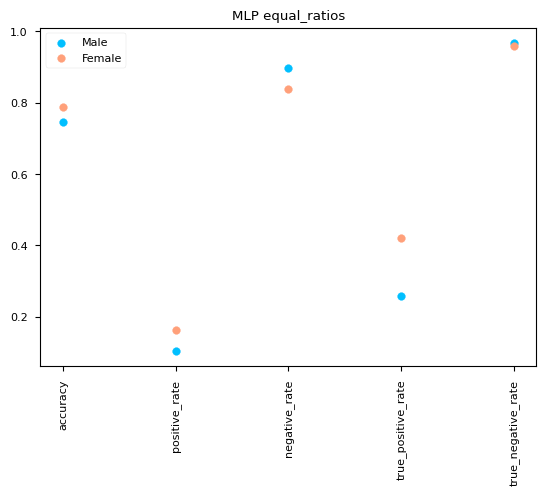

In [69]:
approach_4 = evaluate_predictor_performance(predictions, x_test, y_test)
model_summary("MLP equal_ratios", "", approach_4)

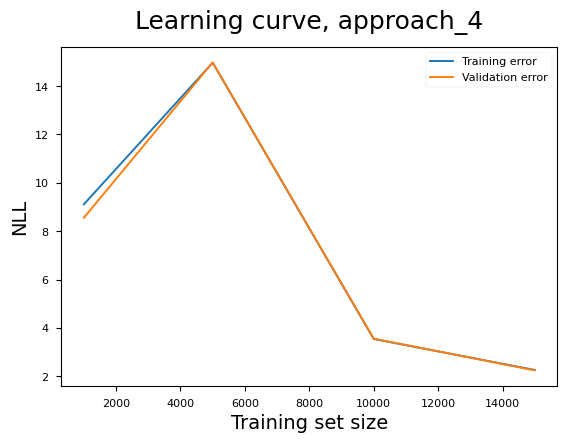

In [70]:
plot_learning_curve(MLPClassifier(), x_train, y_train, default_training_sizes, 'Learning curve, approach_4')

#### Equal ratio of datapoints and gender unawareness

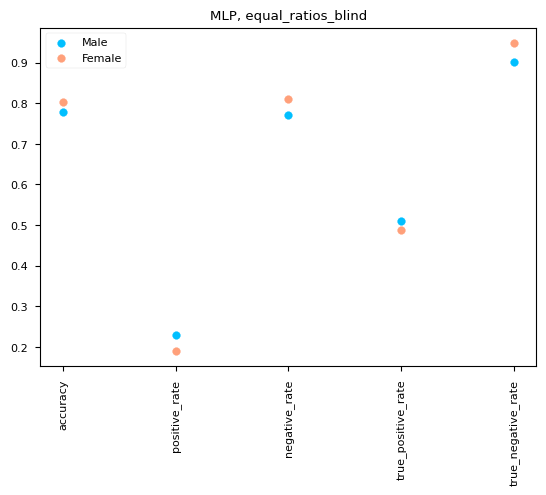

In [71]:
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train.drop(['sex'], axis=1), y_train)
predictions = predictor.predict(x_test.drop(['sex'], axis=1))
approach_4_blind = evaluate_predictor_performance(predictions, x_test, y_test)
model_summary("MLP, equal_ratios_blind", "", approach_4_blind)

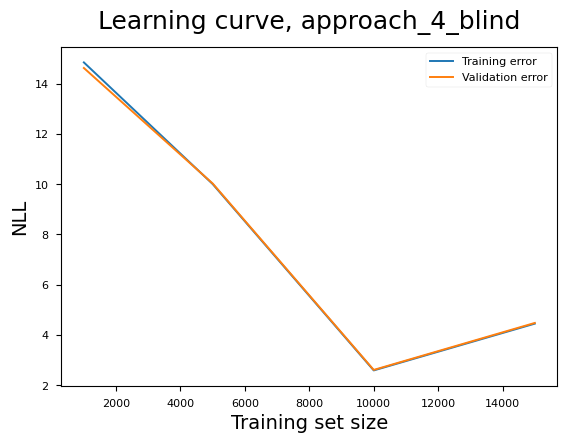

In [72]:
plot_learning_curve(MLPClassifier(), x_train, y_train, default_training_sizes, 'Learning curve, approach_4_blind')

## 4.3 Bias mitigation through data augmentation
In this section we explore bias mitigation approaches that augment existing data with synthetic examples

### 4.3.1 Counterfactual augmentation

In [73]:
def with_gender_counterfacts(df):
    df_out = df.copy()
    df_out['sex'] = df_out['sex'].apply(lambda value: 1-value)
    result = pd.concat([df.copy(), df_out])
    return result

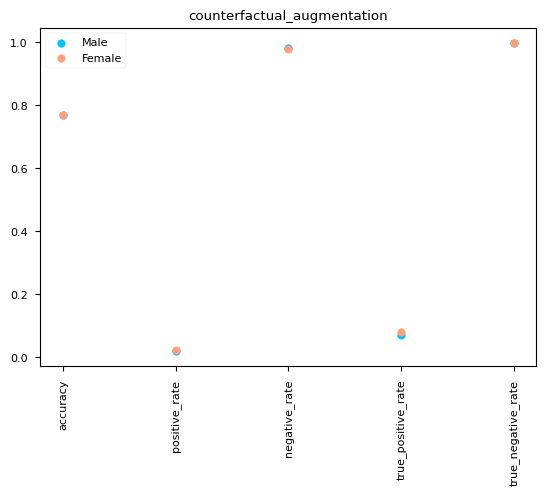

In [74]:
ctf_gender_augmented = with_gender_counterfacts(datav2)
(x_train, y_train), (x_test, y_test) = get_naive_dataset(ctf_gender_augmented)

predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train, y_train)
ctf_1 = evaluate_predictor_performance(predictor.predict(x_test), x_test, y_test)
model_summary("counterfactual_augmentation", "", ctf_1)

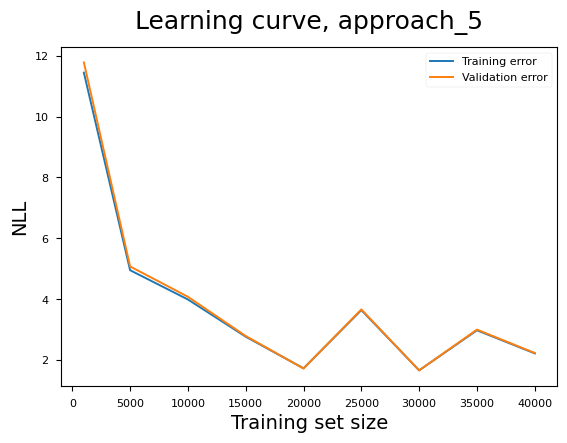

In [75]:
plot_learning_curve(MLPClassifier(), x_train, y_train, default_training_sizes, 'Learning curve, approach_5')

In [76]:
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train.drop(['sex'], axis=1), y_train)

MLPClassifier()

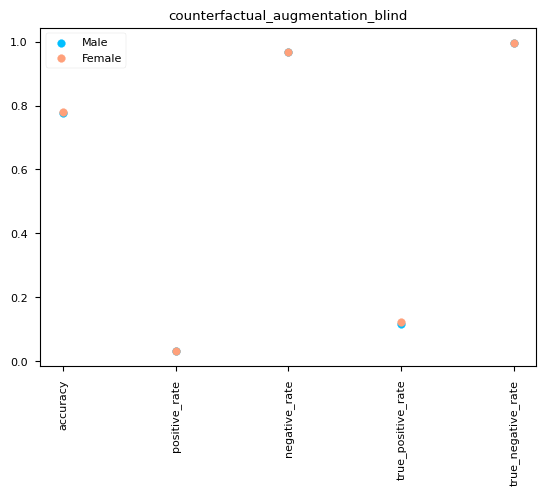

In [77]:
ctf_blind = evaluate_predictor_performance(predictor.predict(x_test.drop(['sex'], axis=1)), x_test, y_test)
model_summary("counterfactual_augmentation_blind", "", ctf_blind)

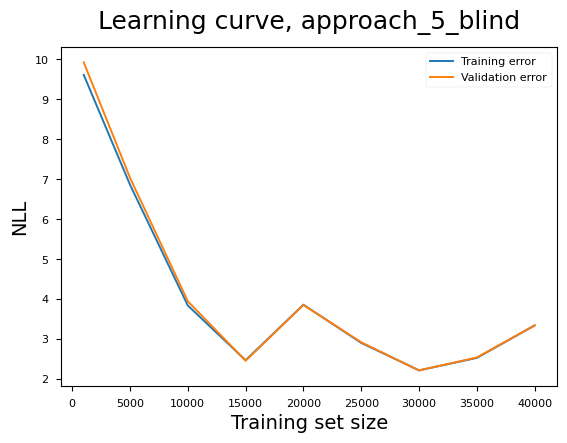

In [78]:
plot_learning_curve(MLPClassifier(), x_train, y_train, default_training_sizes, 'Learning curve, approach_5_blind')

# 5. Comparing bias mitigation approaches
- In the naïve approach, we trained on the entire dataset
- In approach 2, we used gender from our features ( unawareness )
- In approach 3, we used dataset with equal number of samples from the male and female demographics
- In approach 4, we used a dataset with equal number of samples within each income category for the male and female demographics
- In approach 5, we used a dataset with same ratio of number of samples within each income category for the male and female demographics.

In this section, we will be comparing the results of these different approaches

In [79]:
def plot_comparisons(approach_names, accuracy_results, title, fignum=1, rotation='horizontal'):
    """
    Args:
        - summary: Dictionary describing the approach's gender performance
        - approach_name: The name of the technique, to be displayed
    """
    assert isinstance(accuracy_results, list) and not isinstance(accuracy_results[0], list), accuracy_results


    indices = list(range(len(approach_names)))
    colors = cm.rainbow(np.linspace(0, 1, len(indices)))
    plt.figure(fignum)

    for index in indices:
        plt.scatter(index, accuracy_results[index], color=colors[index])

    plt.xticks(indices, approach_names, rotation=rotation)

    plt.title(title)
    plt.show()

def plot_comparisons_groups(approaches, accuracy_results, title, fignum=1, rotation='horizontal', labels=["Male", "Female"]):
    """
    Plot results for 2 groups stacked together
    """
    assert isinstance(accuracy_results, list), "Accuracy results must be a list"


    indices = list(range(len(approaches)))
    colors = ['deepskyblue', 'lightsalmon']
    fig, ax = plt.subplots()

    for index in indices:
        ax.scatter(index, accuracy_results[0][index], c=colors[0], label=labels[0] if labels and index ==0 else None)
        ax.scatter(index, accuracy_results[1][index], c=colors[1], label=labels[1] if labels and index ==0 else None)

    if labels:
        ax.legend()

    plt.xticks(indices, approaches, rotation=rotation)
    plt.title(title)

    plt.show()

In [80]:
approaches = ['no_debias', 'gender_unaware', 'equal_|data|_per_gender', 'if_gender_blind', 'equal_data_per_(gender, category)', 'if_gender_blind' 'equal_data_ratio_per_gender', 'if_blind', 'ctf', 'ctf_blind']
summaries = [original_approach, approach_1, approach_2, approach_2_blind, approach_3, approach_3_blind, approach_4, approach_4_blind, ctf_1, ctf_blind]

## 5.1 Comparing overall accuracies
Here we compare the overall accuracies of each of the 4 approaches

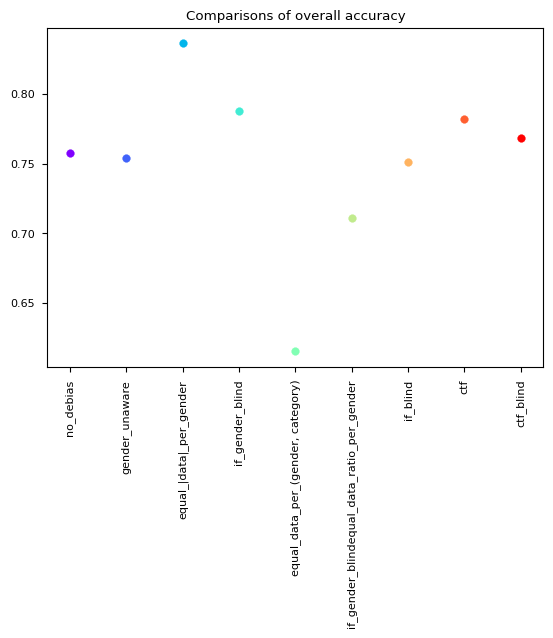

In [81]:
accuracy_results = [summary['accuracy_overall'] for summary in summaries]
plot_comparisons(approaches, accuracy_results, 'Comparisons of overall accuracy', rotation='vertical')

In [82]:
def plot_model_gender_metrics(_feature, _summaries, _modelNames, _title, rotation='vertical'):
    gender_metrics = [[summary[_feature+'_Male'] for summary in _summaries],
                         [summary[_feature+'_Female'] for summary in _summaries]
                        ]
    plot_comparisons_groups(_modelNames,gender_metrics, _title, rotation=rotation)

## 5.2 Comparing overall accuracy across gender

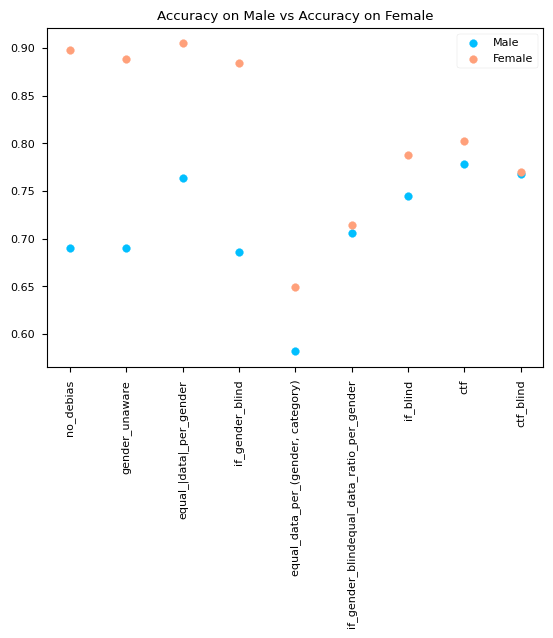

In [83]:
plot_model_gender_metrics('accuracy', summaries, approaches, "Accuracy on Male vs Accuracy on Female")

## 5.3 Positive and negative rates accross gender

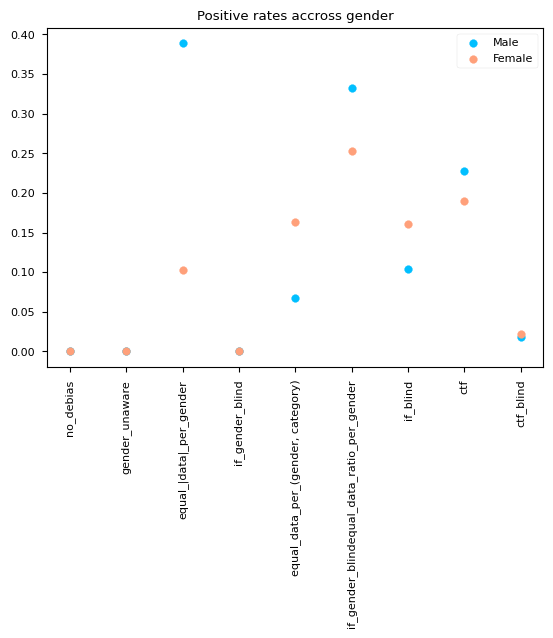

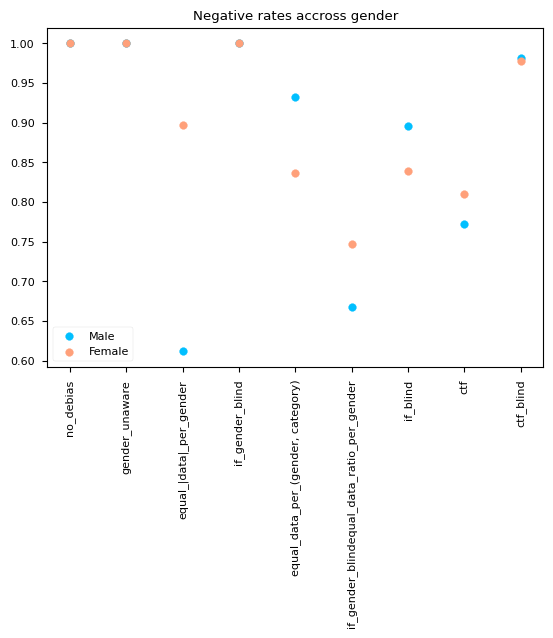

In [84]:
plot_model_gender_metrics('positive_rate', summaries, approaches, "Positive rates accross gender")
plot_model_gender_metrics('negative_rate', summaries, approaches, "Negative rates accross gender")

## 5.4 True positive and True negative across gender

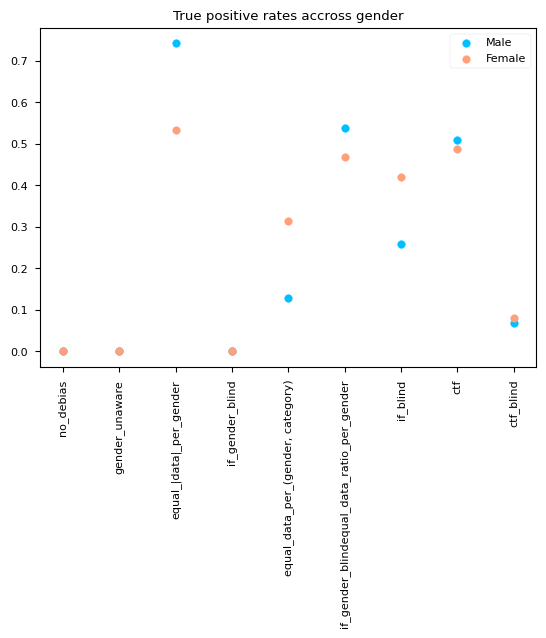

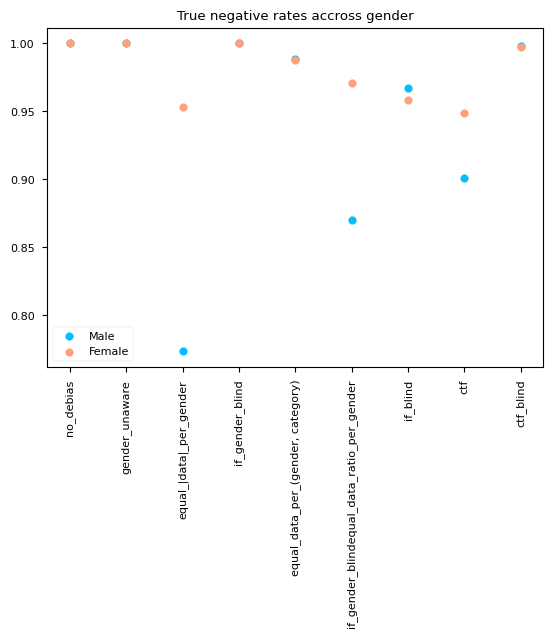

In [85]:
plot_model_gender_metrics('true_positive_rate', summaries, approaches, "True positive rates accross gender")
plot_model_gender_metrics('true_negative_rate', summaries, approaches, "True negative rates accross gender")

## 5.5 True positive rate on positive predictions, and true negative rate on negative predictions

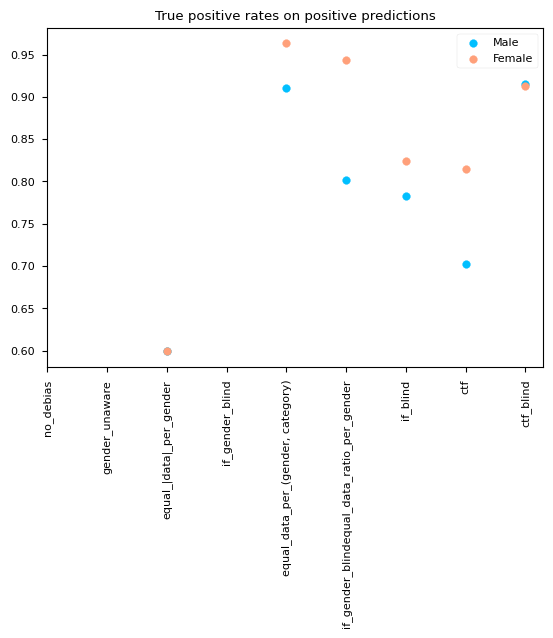

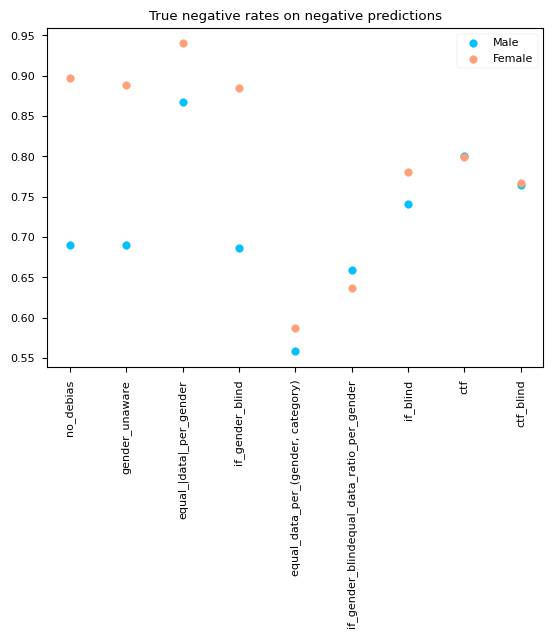

In [86]:
plot_model_gender_metrics('true_positive_rate_on_positive_predictions', summaries, approaches, "True positive rates on positive predictions")
plot_model_gender_metrics('true_negative_rate_on_negative_predictions', summaries, approaches, "True negative rates on negative predictions")

## 5.6 Equalizing opportunity by setting equal true positive and true negative rates for different demographics
We will use the Receive Operating Characteristic(ROC) curve to understand how true positive and true negative rates affect each other accross different demographics


* Diagnostic ability of classifier
* Plots true positive rate (TPR) against the false positive rate (FPR) at various threshold settings
$$TPR = \frac{TP}{TP + FN}$$
$$FPR = \frac{FP}{FP + TN}$$
* Area under the ROC curve (AUC) - single number which reflects model's performance

In [87]:
from sklearn import svm, metrics
clf = MLPClassifier(max_iter=MLP_MAX_ITER)
clf.fit(x_train, y_train)
# obtain the learned decision function and evaluate it on the held-out data

MLPClassifier()

In [88]:
def plot_roc_curve(trained_predictor, X_test_list=None, Y_test_list=None, label_list = None, fignum=None):
    """
    Trained predictor must have .decision_function attribute
    """
    if fignum is not None:
        figure(fignum)
    for index in range(len(X_test_list)):
        X_test = X_test_list[index]
        Y_test = Y_test_list[index]
        assert X_test is not None and Y_test is not None, "X_test and Y_test cannot be None"
        y_pred_scores = trained_predictor.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_scores) # obtain false positive and true positive rates
        area_under_curve = metrics.auc(fpr, tpr)
        label = "for gender = "+  label_list[index] if label_list is not None else ''
        #plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f) %s' % (area_under_curve, label)) # plot ROC curve
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f) %s' % (area_under_curve, label))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

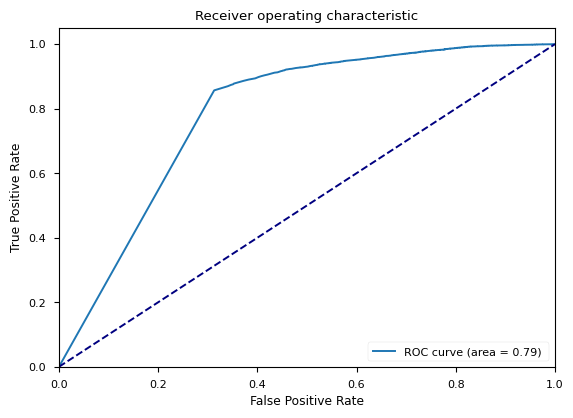

In [89]:
plot_roc_curve(clf, X_test_list = [x_test], Y_test_list = [y_test])

In [90]:
predictor = MLPClassifier(max_iter=MLP_MAX_ITER)
predictor.fit(x_train, y_train)

MLPClassifier()

In [91]:
def plot_gender_roc_curves(trained_predictor, X_test, Y_test):
    """
    Plots the ROC curve for each gender demographic
    """
    combined = pd.concat([X_test, Y_test], axis=1)
    x_test_list, y_test_list, gender_labels = [], [], []
    for gender, gender_label in (("FEMALE", FEMALE_LABEL), ("MALE", MALE_LABEL)):
        with_gender = combined[combined['sex'] == gender_label]
        x_test = with_gender.drop(['salary'], axis=1)
        y_test = with_gender['salary']
        x_test_list.append(x_test)
        y_test_list.append(y_test)
        gender_labels.append(gender)
    plot_roc_curve(predictor, X_test_list=x_test_list, Y_test_list=y_test_list,label_list=gender_labels)

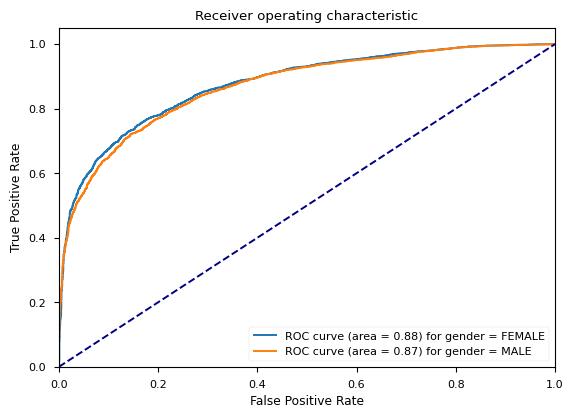

In [92]:
plot_gender_roc_curves(predictor, x_test, y_test)

# 6. Bias mitigation through fair model selection
In this section, we explore different model choices, and look at how model choice affects different metrics. We first start by exploring a short overview of the problem group and it's corresponding algorithm family. Based on that, we will then explore different algorithms for classifications, and understand how they perform overall, and for different demographics over several training sessions.

This is a classification problem, therefore, the different classifiers that we can use are

- Support Vector Machines(SVMs),
- Decision tree learners,
- Instance based learners,
- Generalized linear models, and
- Artificial neural networks.

We are going to use one from each category, in order to get a comparison of how these models perform

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [95]:
LR_MAX_ITER=1000

In [96]:
(x_train, y_train), (x_test, y_test) = get_naive_dataset(datav3)

In [97]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1, max_iter=LR_MAX_ITER) # GLM
rf = RandomForestClassifier(n_estimators=50, random_state=1) # Random Forest
gnb = GaussianNB() # GLM
mlp = MLPClassifier(max_iter=MLP_MAX_ITER)  # ANN
svc = svm.SVC() # SVM
knc = KNeighborsClassifier(n_neighbors=5)
for model in [lr, rf, gnb, mlp, svc, knc]:
    model.fit(x_train, y_train)

In [98]:
for model_name, model in [('LR', lr), ('RF', rf), ('GNB', gnb), ('MLP', mlp), ('svc', svc), ('knc', knc)]:
    print(model_name, ' accuracy: ', accuracy_score(y_test, model.predict(x_test)))

LR  accuracy:  0.8261984786838846
RF  accuracy:  0.8322129842561472
GNB  accuracy:  0.7128958075358217
MLP  accuracy:  0.7834777993985494
svc  accuracy:  0.7531399257031665
knc  accuracy:  0.8218644967274014


# 7. Debiasing through multi-model architecture
A multi-model architecture combines different machine learning models, and makes a prediction by taking into account the predictions of multiple models.

There are different ways in which a multi-model architecture can make a decision, but here, we will be looking at a Voting classifier, that uses either the **Soft Voting rule** or **Majority/Hard voting** rule to make predictions. In Soft-Voting, outputs fom multiple models are averaged. In the majority rule, the majority output/prediction wins

In [99]:
from sklearn.ensemble import VotingClassifier

In [100]:
def default_voting_classifier(voting='hard'):
    lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1, max_iter=LR_MAX_ITER)
    rf = RandomForestClassifier(n_estimators=50, random_state=1)
    gnb = GaussianNB()
    mlp = MLPClassifier(max_iter=MLP_MAX_ITER)
    svc = svm.SVC(probability = voting != 'hard')
    knc = KNeighborsClassifier(n_neighbors=5)
    voter = VotingClassifier(estimators=[('LR', lr), ('RF', rf), ('GNB', gnb), ('MLP', mlp), ('svc', svc)], voting=voting)

    return voter

In [101]:
(x_train, y_train), (x_test, y_test) = get_naive_dataset(datav3)

In [102]:
hardvoter = default_voting_classifier(voting='hard')
softvoter = default_voting_classifier(voting='soft')
for model in [hardvoter, softvoter]:
    model.fit(x_train, y_train)

In [103]:
print('Hard voting accuracy ', accuracy_score(y_test, hardvoter.predict(x_test)))
print('Soft voting accuracy ', accuracy_score(y_test, softvoter.predict(x_test)))

Hard voting accuracy  0.8284096939678047
Soft voting accuracy  0.7947107730408632


You might have noticed that training might take some time. Sometimes it is very useful to store trained models or other statistics to persistent storage, to avoid retraining. Let's implement functionality for that

In [104]:
# Model persistence
import pickle

class Persistence:
    """
    Implements model persistence functionality
    """
    def __init__(self):
        pass

    @staticmethod
    def storeObject(_object, filename):
        pickle_out = open(filename,"wb")
        pickle.dump(_object, pickle_out)
        pickle_out.close()

    @staticmethod
    def loadObjects(filenames=None):
        result = []
        for filename in filenames:
            result.append(pickle.load(open(filename, 'rb')))
        return result

    @staticmethod
    def storeOrLoad(store=False, load=False, names=None, objects=None):
        """
        Returns file names if storing, returns objects if reading
        """
        if store or load:
            assert store != load, 'Cannot store and load'
        if store:
            for _object, name in zip(objects, names):
                Persistence.storeObject(_object, name)
            return 'Stored'
        if load:
            read = Persistence.loadObjects(filenames=names)
            return read

In [105]:
modelNames = ['LR', 'RF', 'GNB', 'MLP', 'SVC', 'hard_voter', 'soft_voter']
models = [lr, rf, gnb, mlp, svc, hardvoter, softvoter]

In [106]:
summaries = []
for model, modelname in zip(models, modelNames):
    summaries.append(evaluate_predictor_performance(model.predict(x_test), x_test, y_test))

# 8. Comparing model performance for single training session

## 8.1 Overall Accuracy

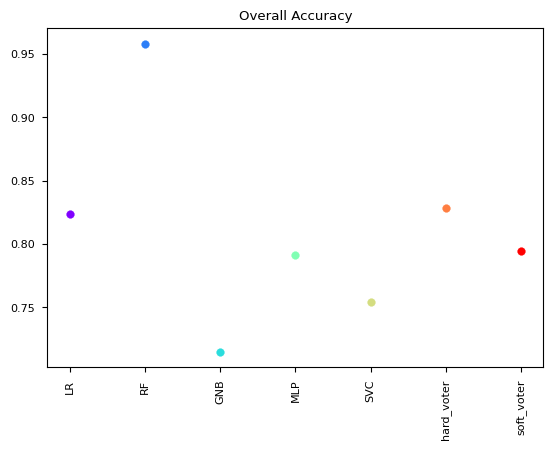

In [107]:
overall_accuracies = [summary['accuracy_overall'] for summary in summaries]
plot_comparisons(modelNames, overall_accuracies, "Overall Accuracy", rotation='vertical')

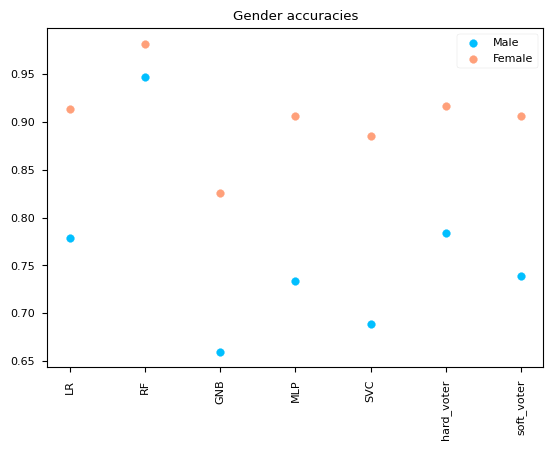

In [108]:
gender_accuracies = [[summary['accuracy_Male'] for summary in summaries], [summary['accuracy_Female'] for summary in summaries]]
plot_comparisons_groups(modelNames, gender_accuracies, "Gender accuracies", rotation='vertical')

## 8.2 Positive and negative rates accross each demographic

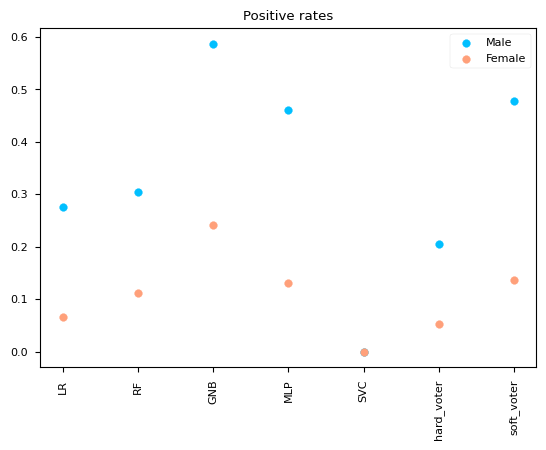

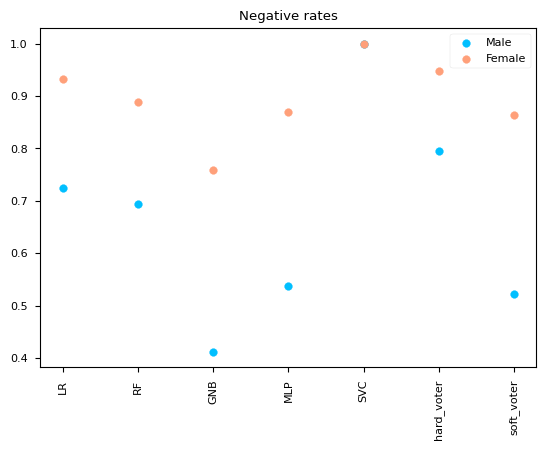

In [109]:
plot_model_gender_metrics('positive_rate', summaries, modelNames, "Positive rates", rotation='vertical')
plot_model_gender_metrics('negative_rate', summaries, modelNames, "Negative rates", rotation='vertical')

## 8.3 True positive and true negative rates across each demographic

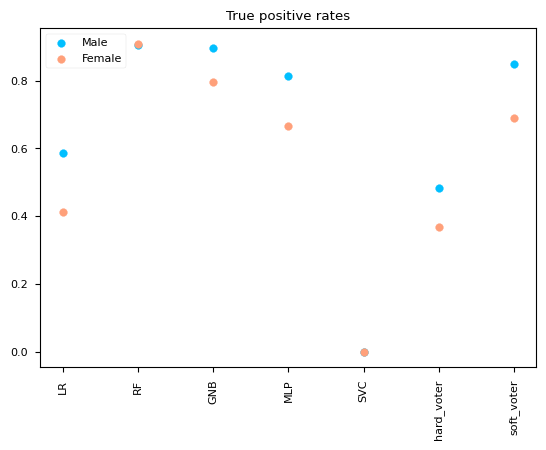

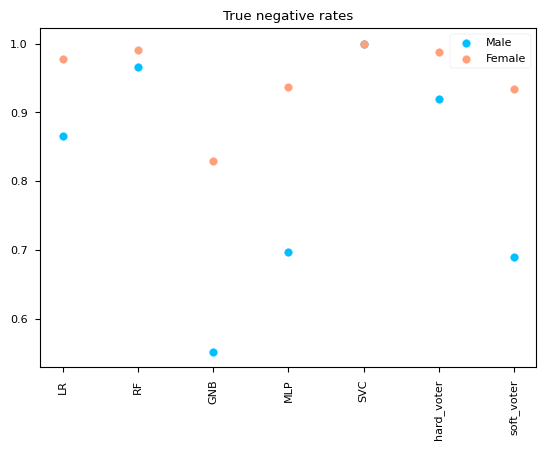

In [110]:
plot_model_gender_metrics('true_positive_rate', summaries, modelNames, "True positive rates", rotation='vertical')
plot_model_gender_metrics('true_negative_rate', summaries, modelNames, "True negative rates", rotation='vertical')

## 8.4 Fairness metrics (Demographic Parity, Disparate Impact, Equal Opportunity, Equalized Odds)

We compute fairness metrics **by `sex` group** for each already-trained model:
- **Demographic Parity (DP):** positive prediction rate per group
- **Disparate Impact (DI):** ratio min(PR_g)/max(PR_g)
- **Equal Opportunity (EO):** difference in **TPR** across groups
- **Equalized Odds:** differences in both **TPR** and **FPR** across groups



In [111]:
def fairness_metrics(y_true, y_pred, groups):
    """Calcule DP/DI/EO pour un vecteur de prédictions binaire et des groupes."""
    res = {}
    for g in np.unique(groups):
        idx = (groups == g)
        yt, yp = y_true[idx], y_pred[idx]
        pr  = (yp == 1).mean()                                   # Demographic parity: P(ŷ=1|g)
        tpr = ((yp==1)&(yt==1)).sum() / max((yt==1).sum(), 1)    # Equal opportunity (TPR)
        fpr = ((yp==1)&(yt==0)).sum() / max((yt==0).sum(), 1)    # Equalized odds (FPR)
        res[str(g)] = {"positive_rate": float(pr), "tpr": float(tpr), "fpr": float(fpr)}
    prs = [v["positive_rate"] for v in res.values()]
    di = (min(prs)/max(prs)) if max(prs) > 0 else 0.0
    dp_diff = max(prs) - min(prs)
    tprs = [v["tpr"] for v in res.values()]
    fprs = [v["fpr"] for v in res.values()]
    eo_tpr_diff = max(tprs) - min(tprs)
    eo_fpr_diff = max(fprs) - min(fprs)
    return res, {
        "disparate_impact": di,
        "dp_diff": dp_diff,
        "eo_tpr_diff": eo_tpr_diff,
        "eo_fpr_diff": eo_fpr_diff
    }

# === Audit fairness pour tous tes modèles déjà entraînés ===
sens = x_test['sex'].astype(str).values
rows = []
for name, mdl in zip(modelNames, models):
    yhat = mdl.predict(x_test)
    by_g, summ = fairness_metrics(y_test.values, yhat, sens)
    print(f"\n{name} — per-group metrics:")
    display(pd.DataFrame(by_g).T)       # détails par groupe (PR, TPR, FPR)
    rows.append({"model": name, **summ})

fairness_df = pd.DataFrame(rows)
display(fairness_df.sort_values("dp_diff"))



LR — per-group metrics:


,positive_rate,tpr,fpr
0,0.933351,0.977818,0.588372
1,0.725199,0.865833,0.413646



RF — per-group metrics:


,positive_rate,tpr,fpr
0,0.888476,0.991307,0.090698
1,0.694960,0.965544,0.095522



GNB — per-group metrics:


,positive_rate,tpr,fpr
0,0.758099,0.829436,0.204651
1,0.412599,0.552647,0.102345



MLP — per-group metrics:


,positive_rate,tpr,fpr
0,0.868826,0.937650,0.334884
1,0.538594,0.697401,0.186780



SVC — per-group metrics:


,positive_rate,tpr,fpr
0,1.0,1.0,1.0
1,1.0,1.0,1.0



hard_voter — per-group metrics:


,positive_rate,tpr,fpr
0,0.947159,0.987710,0.632558
1,0.794695,0.920115,0.516844



soft_voter — per-group metrics:


,positive_rate,tpr,fpr
0,0.863516,0.934652,0.311628
1,0.522016,0.689317,0.151386


,model,disparate_impact,dp_diff,eo_tpr_diff,eo_fpr_diff
4,SVC,1.000000,0.000000,0.000000,0.000000
5,hard_voter,0.839030,0.152464,0.067594,0.115714
1,RF,0.782194,0.193516,0.025763,0.004825
0,LR,0.776984,0.208152,0.111985,0.174726
3,MLP,0.619910,0.330232,0.240249,0.148103
6,soft_voter,0.604524,0.341500,0.245336,0.160242
2,GNB,0.544256,0.345499,0.276790,0.102306


Across most models, Group 0 has a higher positive (selection) rate than Group 1, indicating a systematic disparity in predicted positives. This is reflected in Demographic Parity gaps (e.g., LR dp_diff≈0.208, RF dp_diff≈0.194) and Disparate Impact values below 1 (LR DI≈0.777, RF DI≈0.782). Random Forest exhibits very small TPR/FPR gaps (i.e., close Equalized Odds), while Hard Voter shows a higher selection rate for Group 1 relative to other models and a DI above 0.8. SVC predicts the positive class for everyone (PR=1.0, TPR=1.0, FPR=1.0), which yields perfect parity metrics but no discriminative value.

## 8.5 Post-processing: Group-specific thresholds (improve Demographic Parity)

We adjust decision thresholds **by group (`sex`)** for one already-trained model
to reduce **Demographic Parity** gaps (selection-rate disparity), then we re-compute
the fairness metrics **before/after**.


In [113]:
import numpy as np
import pandas as pd

# --- util: get probabilities for a model (predict_proba or decision_function) ---
def get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        z = model.decision_function(X)
        # min-max to [0,1] for thresholding consistency
        return (z - z.min()) / (z.max() - z.min() + 1e-9)
    raise ValueError(f"Model {type(model).__name__} provides neither predict_proba nor decision_function.")

# --- util: fairness (reuse if already defined) ---
def fairness_metrics(y_true, y_pred, groups):
    res = {}
    for g in np.unique(groups):
        idx = (groups == g)
        yt, yp = y_true[idx], y_pred[idx]
        pr  = (yp == 1).mean()                                   # Demographic Parity (selection rate)
        tpr = ((yp==1)&(yt==1)).sum() / max((yt==1).sum(), 1)    # Equal Opportunity (TPR)
        fpr = ((yp==1)&(yt==0)).sum() / max((yt==0).sum(), 1)    # Equalized Odds (FPR)
        res[str(g)] = {"positive_rate": float(pr), "tpr": float(tpr), "fpr": float(fpr)}
    prs = [v["positive_rate"] for v in res.values()]
    di = (min(prs)/max(prs)) if max(prs) > 0 else 0.0
    dp_diff = max(prs) - min(prs)
    tprs = [v["tpr"] for v in res.values()]
    fprs = [v["fpr"] for v in res.values()]
    eo_tpr_diff = max(tprs) - min(tprs)
    eo_fpr_diff = max(fprs) - min(fprs)
    return res, {"disparate_impact": di, "dp_diff": dp_diff, "eo_tpr_diff": eo_tpr_diff, "eo_fpr_diff": eo_fpr_diff}

# --- select a suitable model to post-process: priority RF -> LR -> soft_voter -> first with proba ---
priority_names = ["RF", "Random Forest", "LR", "Logistic Regression", "soft_voter", "Soft Voter"]
chosen = None
for pref in priority_names:
    for name, mdl in zip(modelNames, models):
        if pref.lower() in str(name).lower():
            try:
                _ = get_scores(mdl, x_test)
                chosen = (name, mdl)
                break
            except Exception:
                pass
    if chosen:
        break
# fallback: first model with scores
if not chosen:
    for name, mdl in zip(modelNames, models):
        try:
            _ = get_scores(mdl, x_test)
            chosen = (name, mdl)
            break
        except Exception:
            continue

assert chosen is not None, "No model with scores found for post-processing."
chosen_name, chosen_model = chosen
print("Chosen model for group-thresholding:", chosen_name)

# --- compute baseline fairness (threshold=0.5) ---
scores = get_scores(chosen_model, x_test)
y_base = (scores >= 0.5).astype(int)
sens = x_test["sex"].astype(str).values

by_g_base, sum_base = fairness_metrics(y_test.values, y_base, sens)
print("\nBaseline (global threshold=0.5):")
display(pd.DataFrame(by_g_base).T)
print(sum_base)

# --- search thresholds per group to match target positive rate (reduce DP gap) ---
def group_thresholds(scores, groups, target_rate=None, grid=np.linspace(0.1, 0.9, 41)):
    if target_rate is None:
        target_rate = (scores >= 0.5).mean()
    thr = {}
    y_hat = np.zeros_like(scores, dtype=int)
    for g in np.unique(groups):
        idx = (groups == g)
        s_g = scores[idx]
        best_t, best_gap = 0.5, 1e9
        for t in grid:
            pr = (s_g >= t).mean()
            gap = abs(pr - target_rate)
            if gap < best_gap:
                best_t, best_gap = t, gap
        thr[str(g)] = float(best_t)
        y_hat[idx] = (scores[idx] >= best_t).astype(int)
    return thr, y_hat

thr, y_thr = group_thresholds(scores, sens)
by_g_thr, sum_thr = fairness_metrics(y_test.values, y_thr, sens)

print("\nAfter group-specific thresholds:")
print("Thresholds by group:", thr)
display(pd.DataFrame(by_g_thr).T)
print(sum_thr)

# --- (optional) log into fairness_df if it exists ---
try:
    fairness_df = pd.concat([
        fairness_df,
        pd.DataFrame([{"model": f"{chosen_name} + group-thresholds", **sum_thr}])
    ], ignore_index=True)
    display(fairness_df)
except NameError:
    pass


Chosen model for group-thresholding: RF

Baseline (global threshold=0.5):


,positive_rate,tpr,fpr
0,0.889272,0.991607,0.095349
1,0.697480,0.967661,0.098934


{'disparate_impact': 0.784326688437025, 'dp_diff': 0.1917923314987794, 'eo_tpr_diff': 0.02394550192377387, 'eo_fpr_diff': 0.003585064709674221}

After group-specific thresholds:
Thresholds by group: {'0': 0.9, '1': 0.28}


,positive_rate,tpr,fpr
0,0.800053,0.900180,0.023256
1,0.770690,0.989028,0.286994


{'disparate_impact': 0.9632981219314007, 'dp_diff': 0.029363451572142707, 'eo_tpr_diff': 0.0888480553382126, 'eo_fpr_diff': 0.2637377894580255}


,model,disparate_impact,dp_diff,eo_tpr_diff,eo_fpr_diff
0,LR,0.776984,0.208152,0.111985,0.174726
1,RF,0.782194,0.193516,0.025763,0.004825
2,GNB,0.544256,0.345499,0.276790,0.102306
3,MLP,0.619910,0.330232,0.240249,0.148103
4,SVC,1.000000,0.000000,0.000000,0.000000
5,hard_voter,0.839030,0.152464,0.067594,0.115714
6,soft_voter,0.604524,0.341500,0.245336,0.160242
7,RF + group-thresholds,0.963298,0.029363,0.088848,0.263738
8,RF + group-thresholds,0.963298,0.029363,0.088848,0.263738


## 8.6 Pre-processing: Reweighting by (group, label) on the training set

We compute simple **sample weights** by the joint distribution of `(sex, y_train)` to
balance representation, then **re-train** a Logistic Regression on a fresh pipeline.
We evaluate fairness on the test set.


In [115]:
import numpy as np
import pandas as pd

# --- util: get probabilities for a model (predict_proba or decision_function) ---
def get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        z = model.decision_function(X)
        # min-max to [0,1] for thresholding consistency
        return (z - z.min()) / (z.max() - z.min() + 1e-9)
    raise ValueError(f"Model {type(model).__name__} provides neither predict_proba nor decision_function.")

# --- util: fairness (DP/DI/EO) ---
def fairness_metrics(y_true, y_pred, groups):
    res = {}
    for g in np.unique(groups):
        idx = (groups == g)
        yt, yp = y_true[idx], y_pred[idx]
        pr  = (yp == 1).mean()                                   # Demographic Parity (selection rate)
        tpr = ((yp==1)&(yt==1)).sum() / max((yt==1).sum(), 1)    # Equal Opportunity (TPR)
        fpr = ((yp==1)&(yt==0)).sum() / max((yt==0).sum(), 1)    # Equalized Odds (FPR)
        res[str(g)] = {"positive_rate": float(pr), "tpr": float(tpr), "fpr": float(fpr)}
    prs = [v["positive_rate"] for v in res.values()]
    di = (min(prs)/max(prs)) if max(prs) > 0 else 0.0
    dp_diff = max(prs) - min(prs)
    tprs = [v["tpr"] for v in res.values()]
    fprs = [v["fpr"] for v in res.values()]
    eo_tpr_diff = max(tprs) - min(tprs)
    eo_fpr_diff = max(fprs) - min(fprs)
    return res, {"disparate_impact": di, "dp_diff": dp_diff, "eo_tpr_diff": eo_tpr_diff, "eo_fpr_diff": eo_fpr_diff}

# --- select a suitable model to post-process: priority RF -> LR -> soft_voter -> first with proba ---
priority_names = ["RF", "Random Forest", "LR", "Logistic Regression", "soft_voter", "Soft Voter"]
chosen = None
for pref in priority_names:
    for name, mdl in zip(modelNames, models):
        if pref.lower() in str(name).lower():
            try:
                _ = get_scores(mdl, x_test)
                chosen = (name, mdl)
                break
            except Exception:
                pass
    if chosen:
        break
# fallback: first model with scores
if not chosen:
    for name, mdl in zip(modelNames, models):
        try:
            _ = get_scores(mdl, x_test)
            chosen = (name, mdl)
            break
        except Exception:
            continue

assert chosen is not None, "No model with scores found for post-processing."
chosen_name, chosen_model = chosen
print("Chosen model for group-thresholding:", chosen_name)

# --- baseline fairness (threshold=0.5) ---
scores = get_scores(chosen_model, x_test)
y_base = (scores >= 0.5).astype(int)
sens = x_test["sex"].astype(str).values

by_g_base, sum_base = fairness_metrics(y_test.values, y_base, sens)
print("\nBaseline (global threshold=0.5):")
display(pd.DataFrame(by_g_base).T)
print(sum_base)

# --- thresholds per group to reduce DP gap ---
def group_thresholds(scores, groups, target_rate=None, grid=np.linspace(0.1, 0.9, 41)):
    if target_rate is None:
        target_rate = (scores >= 0.5).mean()
    thr = {}
    y_hat = np.zeros_like(scores, dtype=int)
    for g in np.unique(groups):
        idx = (groups == g)
        s_g = scores[idx]
        best_t, best_gap = 0.5, 1e9
        for t in grid:
            pr = (s_g >= t).mean()
            gap = abs(pr - target_rate)
            if gap < best_gap:
                best_t, best_gap = t, gap
        thr[str(g)] = float(best_t)
        y_hat[idx] = (scores[idx] >= best_t).astype(int)
    return thr, y_hat

thr, y_thr = group_thresholds(scores, sens)
by_g_thr, sum_thr = fairness_metrics(y_test.values, y_thr, sens)

print("\nAfter group-specific thresholds:")
print("Thresholds by group:", thr)
display(pd.DataFrame(by_g_thr).T)
print(sum_thr)

# --- (optional) append to fairness_df if it exists ---
try:
    fairness_df = pd.concat([
        fairness_df,
        pd.DataFrame([{"model": f"{chosen_name} + group-thresholds", **sum_thr}])
    ], ignore_index=True)
    display(fairness_df)
except NameError:
    pass


Chosen model for group-thresholding: RF

Baseline (global threshold=0.5):


,positive_rate,tpr,fpr
0,0.889272,0.991607,0.095349
1,0.697480,0.967661,0.098934


{'disparate_impact': 0.784326688437025, 'dp_diff': 0.1917923314987794, 'eo_tpr_diff': 0.02394550192377387, 'eo_fpr_diff': 0.003585064709674221}

After group-specific thresholds:
Thresholds by group: {'0': 0.9, '1': 0.28}


,positive_rate,tpr,fpr
0,0.800053,0.900180,0.023256
1,0.770690,0.989028,0.286994


{'disparate_impact': 0.9632981219314007, 'dp_diff': 0.029363451572142707, 'eo_tpr_diff': 0.0888480553382126, 'eo_fpr_diff': 0.2637377894580255}


,model,disparate_impact,dp_diff,eo_tpr_diff,eo_fpr_diff
0,LR,0.776984,0.208152,0.111985,0.174726
1,RF,0.782194,0.193516,0.025763,0.004825
2,GNB,0.544256,0.345499,0.276790,0.102306
3,MLP,0.619910,0.330232,0.240249,0.148103
4,SVC,1.000000,0.000000,0.000000,0.000000
5,hard_voter,0.839030,0.152464,0.067594,0.115714
6,soft_voter,0.604524,0.341500,0.245336,0.160242
7,RF + group-thresholds,0.963298,0.029363,0.088848,0.263738
8,RF + group-thresholds,0.963298,0.029363,0.088848,0.263738
9,RF + group-thresholds,0.963298,0.029363,0.088848,0.263738


### Concise interpretation (RF by `sex`)

* **Baseline (global threshold = 0.5):** clear selection gap (**PR 0.889 vs 0.697**; **DI = 0.784**, **dp_diff = 0.192**), while **errors are well balanced** (**TPR diff ≈ 0.024**, **FPR diff ≈ 0.0036**).
* **After group-specific thresholds** *(g0 = 0.90, g1 = 0.28)*: **Demographic Parity improves strongly** (**PR 0.800 vs 0.771**; **DI = 0.963**, **dp_diff = 0.029**), but **Equalized Odds worsens** (**TPR diff ≈ 0.089**, **FPR diff ≈ 0.264**).
* **Error pattern:** Group 1 now has **much higher FPR** (**0.287**) than Group 0 (**0.023**) while TPR remains high in both.
* **Bottom line:** post-processing **trades selection parity for error parity**—better **DP**, worse **EO**, with substantially **more false positives** in Group 1.


# 9. Comparing model performance over multiple training sessions
From a single training session, the results are random, therefore our conclusion on the which model performs best is still weak. Doing more than a single training sessions helps get a better idea of what models performs best in the average case.

We first start by implementing functionality for training instances of a model class, and summarizing the results over multiple traning sessions

In [ ]:
def get_model_class_summaries(model_class, dataset, training_sessions, *args, **kwargs):
    """
    Repeatedly sample from the dataset, train, test and return summary statistics
    """
    assert training_sessions >= 1, "Must train at least once"

    Xvals, Yvals = dataset
    summaries = []
    for session in range(training_sessions):
        x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=.25)
        model = model_class(*args, **kwargs)
        model.fit(x_train, y_train)

        evaluation = evaluate_predictor_performance(model.predict(x_test), x_test, y_test)
        summaries.append(evaluation)

    assert len(summaries) == training_sessions
    return summaries

Let's now get an idea of what the training summaries are going to look like. We do this by traning an instance of MLPClassifier for 3 times, and aggregating the summaries

In [ ]:
dataset = datav3.copy()
Xvals=dataset.drop(["salary"], axis=1)
Yvals = dataset["salary"]
some_summaries = get_model_class_summaries(MLPClassifier, (Xvals, Yvals), 2, max_iter=MLP_MAX_ITER)
some_summaries[:2]

[{'accuracy_overall': 0.8359278259331329,
  'accuracy_Female': 0.9163055254604551,
  'accuracy_Male': 0.7969529813501445,
  'positive_rate_Female': 0.09100758396533044,
  'positive_rate_Male': 0.3177042290517468,
  'negative_rate_Female': 0.9089924160346695,
  'negative_rate_Male': 0.6822957709482532,
  'true_positive_rate_Female': 0.5347043701799485,
  'true_negative_rate_Female': 0.9612473508931274,
  'true_positive_rate_on_positive_predictions_Female': 0.6190476190476191,
  'true_negative_rate_on_negative_predictions_Female': 0.9460667461263409,
  'true_positive_rate_Male': 0.6842549598986915,
  'true_negative_rate_Male': 0.8478551000953289,
  'true_positive_rate_on_positive_predictions_Male': 0.670111616370401,
  'true_negative_rate_on_negative_predictions_Male': 0.8560153994225217},
 {'accuracy_overall': 0.8321245356447904,
  'accuracy_Female': 0.9140197152245345,
  'accuracy_Male': 0.7930493859419911,
  'positive_rate_Female': 0.10323110624315443,
  'positive_rate_Male': 0.300627

## 9.1 Aggregate results for single-model architectures

In [ ]:
single_model_name_classes_args_kwargs = [
    ['LR', LogisticRegression,     [], {'solver': 'lbfgs', 'multi_class': 'multinomial', 'random_state':1, 'max_iter':LR_MAX_ITER}],
    ['RF', RandomForestClassifier, [], {'n_estimators':50, 'random_state':1}],
    ['GNB', GaussianNB,             [], {}],
    ['MLPC', MLPClassifier,          [], {'max_iter':MLP_MAX_ITER}],
    ['SVC', svm.SVC,                [], {}]
]

In [ ]:
single_model_summaries = []

In [ ]:
runLoop = True # simply set runLoop to False to avoid iterations
if runLoop:
    for name, model_class, args, kwargs in single_model_name_classes_args_kwargs:
        model_class_summaries = get_model_class_summaries(model_class, (Xvals, Yvals), 5, *args, **kwargs)
        single_model_summaries.append((name, model_class_summaries))

In [ ]:
store = True # Change the flag to store the summaries
if store:
    Persistence.storeOrLoad(store=True, names=['single_model_summaries'], objects = [single_model_summaries])

In [ ]:
voting_model_name_classes_args_kwargs = [
    ['hard_voting', default_voting_classifier, [], {'voting':'hard'}],
    ['soft_voting', default_voting_classifier, [], {'voting':'soft'}]
]

## 9.2 Aggregate results for multi-model architectures

In [ ]:
voting_model_summaries = []

In [ ]:
runLoop = True
if runLoop:
    for name, model_class, args, kwargs in voting_model_name_classes_args_kwargs:
        model_class_summaries = get_model_class_summaries(model_class, (Xvals, Yvals), 5, *args, **kwargs)
        voting_model_summaries.append((name, model_class_summaries))

In [ ]:
assert [len(voting_model_summaries) > 0]
Persistence.storeOrLoad(store=True, names=['voting_model_summaries'], objects=[voting_model_summaries])

'Stored'

In [ ]:
def extract_treatment_differences(summaries):
    """
    Extract treatment difference(male-female) from a performance summary
    """
    differences = []
    for summary_dict in summaries:
        gender_attrs = set()
        for gender_key in summary_dict:
            if '_Male' in gender_key:
                gender_attrs.add(gender_key[:gender_key.rindex('_')])
        value_dict = {}
        for gender_attr in gender_attrs:
            value_dict[gender_attr] = summary_dict[gender_attr+"_Male"] - summary_dict[gender_attr+ "_Female"]
        differences.append(value_dict)
    return differences

In [ ]:
all_model_summaries = single_model_summaries + voting_model_summaries

In [ ]:
store = True # set to True to store all model summaries
if store:
    Persistence.storeOrLoad(store=True, names=['all_model_summaries'], objects=[all_model_summaries])

In [ ]:
load = True # Set to true to load stored models
if load:
    all_model_summaries = Persistence.storeOrLoad(load=load, names=['all_model_summaries'])[0]

In [ ]:
all_model_summaries[-2:]

[('hard_voting',
  [{'accuracy_overall': 0.8483106315230851,
    'accuracy_Female': 0.9252487227749395,
    'accuracy_Male': 0.8105970739422697,
    'positive_rate_Female': 0.0803979564399032,
    'positive_rate_Male': 0.2860155529194675,
    'negative_rate_Female': 0.9196020435600968,
    'negative_rate_Male': 0.7139844470805324,
    'true_positive_rate_Female': 0.5267175572519084,
    'true_negative_rate_Female': 0.9723391461214672,
    'true_positive_rate_on_positive_predictions_Female': 0.6923076923076923,
    'true_negative_rate_on_negative_predictions_Female': 0.9456140350877194,
    'true_positive_rate_Male': 0.6553624417125901,
    'true_negative_rate_Male': 0.8806426931905126,
    'true_positive_rate_on_positive_predictions_Male': 0.712442396313364,
    'true_negative_rate_on_negative_predictions_Male': 0.8499169281890345},
   {'accuracy_overall': 0.8425614717848929,
    'accuracy_Female': 0.9123809523809524,
    'accuracy_Male': 0.8089372297208753,
    'positive_rate_Female':

In [ ]:
all_model_differences = []

In [ ]:
for model_name, model_summaries in all_model_summaries:
    differences = extract_treatment_differences(model_summaries)
    all_model_differences.append((model_name, differences))

In [ ]:
all_model_differences[:1]

[('LR',
  [{'true_negative_rate': -0.08459174841155437,
    'positive_rate': 0.19012875140330096,
    'accuracy': -0.11317520376975787,
    'true_positive_rate': 0.15354332280591082,
    'true_positive_rate_on_positive_predictions': 0.012292628074069833,
    'true_negative_rate_on_negative_predictions': -0.09877600277062393,
    'negative_rate': -0.19012875140330088},
   {'true_negative_rate': -0.0914150723283067,
    'positive_rate': 0.20291773808733718,
    'accuracy': -0.10898339346655594,
    'true_positive_rate': 0.18736190277955683,
    'true_positive_rate_on_positive_predictions': -0.008677573894965152,
    'true_negative_rate_on_negative_predictions': -0.08842646529263487,
    'negative_rate': -0.20291773808733715},
   {'true_negative_rate': -0.08450991392678442,
    'positive_rate': 0.1881485494061964,
    'accuracy': -0.11491098675736189,
    'true_positive_rate': 0.14069614668104719,
    'true_positive_rate_on_positive_predictions': 0.008519538282325545,
    'true_negative_r

## 9.3 Plotting model performance differences
We now implement functionalities for plotting the aggregated statistics to get a visual understanding of each model's performance in terms of gender disparity

In [ ]:
def get_model_values_for_feature(feature, nsp, abs_val=False):
    """
    Inputs:
        nsp = name summary pairs
    """
    model_names = [model_summary[0] for model_summary in nsp]
    model_summary_lists = [model_summary[1] for model_summary in nsp] # Each element is a list of dicts
    model_y_values = []
    for model_summary_list in model_summary_lists:
        values = [abs(model_summary[feature]) if abs_val else model_summary[feature] for model_summary in model_summary_list]
        model_y_values.append(values)
    return model_names, model_y_values

def plot_model_values_for_feature(model_names, model_y_values, title, rotation='vertical'):

    indices = list(range(len(model_names)))

    colors = cm.rainbow(np.linspace(0, 1, len(indices)))

    fig, ax = plt.subplots()

    for index in indices:
        for y_value in model_y_values[index]:
            ax.scatter(index, abs(y_value), color=colors[index], label=model_names[index])
    plt.xticks(indices, model_names, rotation=rotation)
    #plt.yticks([0])
    plt.title(title)

    plt.show()

def plot_feature_differences(feature_name, model_differences, title):
    model_names, model_y_values = get_model_values_for_feature(feature_name, all_model_differences)
    plot_model_values_for_feature(model_names, model_y_values, title)

## 9.4 Accuracy difference comparison

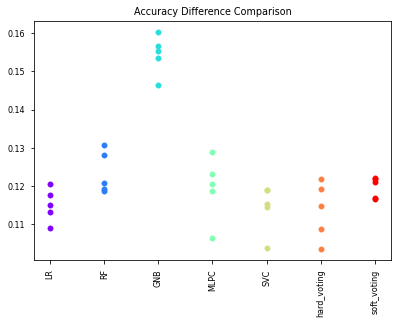

In [ ]:
plot_feature_differences('accuracy', all_model_differences, 'Accuracy Difference Comparison')

## 9.5 Positive and negative rate difference comparison

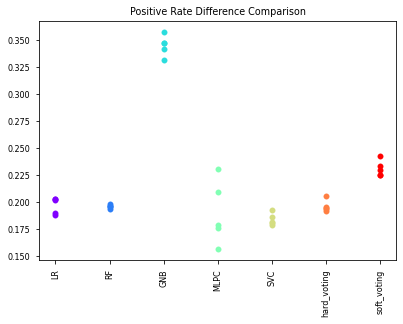

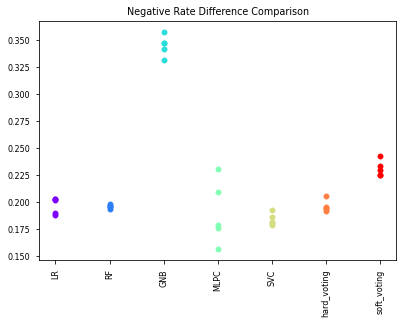

In [ ]:
pl = [('positive_rate', 'Positive Rate'), ('negative_rate', 'Negative Rate')]
for feature, title in pl:
    plot_feature_differences(feature, all_model_differences, title+ ' Difference Comparison')

## 9.6 True positive and true negative rate difference comparison

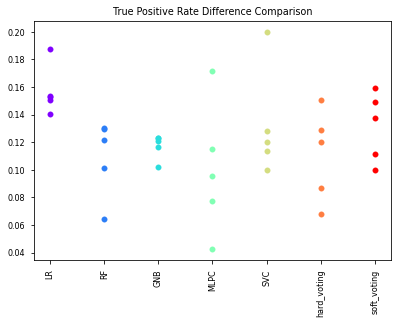

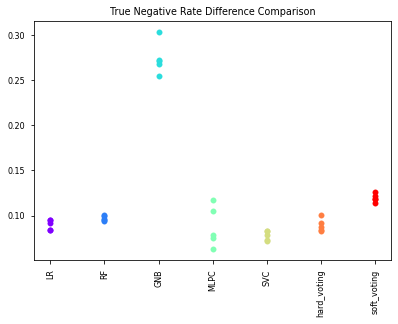

In [ ]:
pl = [('true_positive_rate', 'True Positive Rate'), ('true_negative_rate', 'True Negative Rate')]
for feature, title in pl:
    plot_feature_differences(feature, all_model_differences, title+ ' Difference Comparison')